# Exploring belief estimation, orphans, etc.

### Propagating Belief: relation correctness as a function of statement relations

In [30]:
# Collect all statements that are supported by statements that were already curated.
all_stmts_dict = {stmt.get_hash(): stmt for stmt in all_stmts}
#linked_stmts = []
supp_hashes = {}
sample_k = 100
random.seed(1) # For reproducibility in sampling
for correct_val in (0, 1):
    stmt_hashes = kge_df[kge_df.correct == correct_val].stmt_hash.values
    supp_by_stmts = [sb_stmt for stmt_hash in stmt_hashes
                                 for sb_stmt in all_stmts_dict[stmt_hash].supported_by
                                 if None not in sb_stmt.agent_list()]    
    supp_stmts = [sb_stmt for stmt_hash in stmt_hashes
                              for sb_stmt in all_stmts_dict[stmt_hash].supports
                              if None not in sb_stmt.agent_list()]
    supp_hashes[correct_val] = {'supports': [s.get_hash() for s in supp_stmts],
                                'supported_by': [s.get_hash() for s  in supp_by_stmts]}
    """
    supp_by_hashes_not_none = set([s.get_hash() for s in supp_by_stmts_raw if None not in s.agent_list()])
    supp_hashes_not_none = set([s.get_hash() for s in supp_stmts_raw if None not in s.agent_list()])
    supp_by_stmts = [all_stmts_dict[h] for h in supp_by_hashes_not_none]
    supp_stmts = [all_stmts_dict[h] for h in supp_hashes_not_none]
    """
    """
    if len(supp_stmts) > sample_k:
        supp_stmts = random.sample(supp_stmts, sample_k)
    if len(supp_by_stmts) > sample_k:
        supp_by_stmts = random.sample(supp_by_stmts, sample_k)
    """
    #ac.dump_statements(supp_stmts, f'bioexp_supp_stmts_corr{correct_val}.pkl')
    #ac.dump_statements(supp_by_stmts, f'bioexp_supp_by_stmts_corr{correct_val}.pkl')
    print("correct", correct_val, "supp_by", len(supp_by_stmts))
    print("correct", correct_val, "supp", len(supp_stmts))
    

correct 0 supp_by 42
correct 0 supp 78
correct 1 supp_by 589
correct 1 supp 1809


In [32]:
# Get the curations for the supports/supported_by statements
refinement_data_file  = 'refinement_dataset.pkl'
ref_df = load_curation_data(refinement_data_file)

In [33]:
supp_df_hashes = set(ref_df.stmt_hash.values)
for correct_val, supp_dict in supp_hashes.items():
    for supp_type, hash_list in supp_dict.items():
        num_curated = len(set(hash_list).intersection(supp_df_hashes))
        print(f"Correct {correct_val}, {supp_type}: {num_curated} / {len(hash_list)}")
        

Correct 0, supports: 77 / 141
Correct 0, supported_by: 41 / 106
Correct 1, supports: 67 / 1550
Correct 1, supported_by: 107 / 609


## Training and Evaluating Models

Turn curation dataframe into a set of statements with associated correctness values.

DEPRECATED (See other notebook)

In [44]:
# Function to train different models
# Orphaned code
# Option 1: include stmt_type (encoded) and score
#df = kge_join.drop(columns=['stmt_hash', 'stmt_num', 'agA_name', 'agB_name'])
#le = LabelEncoder()
#le.fit(df.stmt_type)
#df.stmt_type = le.transform(df.stmt_type)

# Option 2: Only include binarized reader info
#reader_list = ['rlimsp', 'medscan', 'trips', 'reach', 'sparser']
#readers_to_include = ['reach', 'sparser']
# readers_to_include = reader_list

# Get training set

def eval_models_relation(model_dict, df, readers, split_func, test_split=0.2, num_folds=10,
                         cols_to_include=None):
    # Encode stmt_type
    df = df.copy()
    for col in ('agA_ns', 'agB_ns', 'stmt_type'):
        le = LabelEncoder()
        le.fit(df[col])
        df[col] = le.transform(df[col])
    # Filter to columns where at least one of the readers has an entry
    df = df[df[readers].any(1)]
    if cols_to_include is None:
        cols_to_include = readers + ['correct']
    df = df[cols_to_include] 
    print(cols_to_include)
    # Get dataset with int-encoded statement type and no class attribute (correct)
    x_df = df.drop('correct', axis=1)
    x = x_df.values
    # Class vector
    y = df.correct.values

    test_size = int(len(y) * test_split)
    # FIXME FIXME Make these parameters!

    predictors = {'': x, #'All features': x,
                  #'Without KGE': x[:, :-1], # Drop the score column
                  #'Only KGE': x[:, -1:]} # Only the score column
                 }

    clf_results = {}
    roc_results = {}
    roc_aucs= {}
    prec_results = {}
    rec_results = {}
    pr_aucs = {}
    # For each model...
    base_fpr = np.linspace(0, 1, 101)
    for clf_name, clf in model_dict.items():
        # Try different sets of features (predictors)...
        for pred_name, pred_x in predictors.items():
            # Fold the data multiple times
            # Save the data in a matrix (num_folds, test_size)
            tpr_arr = np.zeros((num_folds, len(base_fpr)))
            prec_arr = np.zeros((num_folds, len(base_fpr)))
            rec_arr = np.zeros((num_folds, len(base_fpr)))
            roc_auc_arr = np.zeros(num_folds)
            pr_auc_arr = np.zeros(num_folds)
            for fold_ix in tqdm(range(num_folds)):
                # Split the data
                x_train, x_test, y_train, y_test = split_func(pred_x, y, test_size=test_size)                
                # Train the model
                # ExactProb model gets all the data, both training and test
                if clf_name == 'ExactProb':
                    clf.fit(pred_x, y)
                else:
                    clf.fit(x_train, y_train)
                # Save the data
                clf_result = {}
                clf_result['y_preds'] = clf.predict(x_test)
                clf_result['y_probs'] = clf.predict_proba(x_test)

                # Compute ROC curve and ROC area for each model
                fpr, tpr, thresholds = roc_curve(y_test, clf_result['y_probs'][:, 1])
                roc_auc = auc(fpr, tpr)
                tpr_interp = interp(base_fpr, fpr, tpr)
                tpr_interp[0] = 0.0
                tpr_arr[fold_ix, :] = tpr_interp
                roc_auc_arr[fold_ix] = roc_auc
                # Precision/recall/thresholds for each model
                precision, recall, thresholds = precision_recall_curve(y_test, clf_result['y_probs'][:, 1])
                pr_auc = metrics.auc(recall, precision)
                pr_auc_arr[fold_ix] = pr_auc
                prec_arr[fold_ix, :] = interp(base_fpr, thresholds, precision[:-1])
                rec_arr[fold_ix, :] = interp(base_fpr, thresholds, recall[:-1])
            # Save the results for this model/predictor pair from all folds
            model_key = '%s %s' % (clf_name, pred_name)
            roc_results[model_key] = tpr_arr.mean(axis=0)
            clf_results[model_key] = clf_result
            roc_aucs[model_key] = roc_auc_arr
            prec_results[model_key] = prec_arr.mean(axis=0)
            rec_results[model_key] = rec_arr.mean(axis=0)
            pr_aucs[model_key] = pr_auc_arr
    return {'clf': clf_results,
            'roc': roc_results,
            'roc_auc': roc_aucs,
            'prec': prec_results,
            'rec': rec_results,
            'pr_auc': pr_aucs,
            'x_interp': base_fpr}

In [45]:
# Function to plot mean ROC from k-fold cross-validation
def plot_roc(results):
    plt.figure()
    lw = 2
    colors = ['r', 'g', 'b', 'orange', 'k', 'y', 'c', 'm']

    # Plot ROC curve for Belief Model (REACH)
    #plt.plot(bel_fpr, bel_tpr, color=colors[0],
    #         lw=lw, label='Orig. Belief (area = %0.2f)' % bel_roc_auc)
    roc_results = results['roc']
    roc_auc = results['roc_auc']
    for i, (clf_name, roc_result) in enumerate(roc_results.items()):
        roc_auc_arr = roc_auc[clf_name]
        plt.plot(results['x_interp'], roc_result, color=colors[i],
             lw=lw, label='%s (area = %0.2f +/- %0.2f)' %
                          (clf_name, roc_auc_arr.mean(), roc_auc_arr.std()))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [46]:
# Function to plot mean precision-recall curve from k-fold cross validation
def plot_prc(results):
    plt.figure()
    lw = 2
    colors = ['r', 'g', 'b', 'orange', 'k', 'y', 'c', 'm']
    for i, clf_name, in enumerate(results['prec']):
        prec_arr = results['prec'][clf_name]
        rec_arr = results['rec'][clf_name]
        pr_auc = results['pr_auc'][clf_name]                                   
        plt.plot(rec_arr, prec_arr, color=colors[i],
             lw=lw, label='%s (area = %0.2f +/- %0.2f)' %
                          (clf_name, pr_auc.mean(), pr_auc.std()))
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()    
 

### Comparison of approaches to predict correctness at the relation level

DEPRECATED. EMPHASIS IS ON PREDICTING CORRECTNESS AT MENTION LEVEL.

Using our curated dataset, we evaluated several types of models for their ability discriminate between correct and incorrect relations. We used both the unweighted curation dataset and a resampled dataset where the distribution of reader combinations was drawn from the full relation corpus and the class (correctness) was sampled from the subset of entries in the curation dataset for that combination. To establish an upper limit of performance we used a classifier with access to the exact probabilities of correctness for each reader combination from the full dataset (both training and test). The other models included a Logistic Regression model, Random Forest, Bernoulli Naive Bayes, Belief, and a second-order approximation of the joint probability distribution (BL2).

In [41]:
# Resample the curation data to match reader frequency distribution
def resample_curation_data(all_ev_ctr_dict, df_ev_dict, df_subgroup_dict,
                           tgt_size=30000, sampling='weighted'):
    """Generate a new dataset by resampling from curation dataset.
    
    Parameters
    ----------
    sampling : str
        Type of sampling, 'uniform' or 'weighted'. If uniform, all reader combinations
        are equally represented. If 'weighted' (default), follows frequency distribution from
        all_ev_ctr_dict. 
    """
    # Uniform sampling
    if sampling == 'uniform':
        tgt_frac = 1 / len(df_ev_dict)
        all_ev_adj_dict = {}
        for ev_combo in df_ev_dict:
            all_ev_adj_dict[ev_combo] = tgt_frac
    # Resample proportions from the original corpus to allow only those combos found in the
    # curation dataset
    else:
        adjust_total = 0
        for k, v in all_ev_ctr_dict.items():
            if k in df_ev_dict:
                adjust_total += v
            else:
                print(f"{k} not yet curated. Freq in corpus {v}.")
        all_ev_adj_dict = {k: (v/adjust_total) for k, v in all_ev_ctr_dict.items() if k in df_ev_dict}
        # Note that the adjusted dictionary only accounts for 80% of the statement evidence combinations
        # in the original dataset
        print("Adjusted total percentage:", adjust_total)

    # Now, iterate over each combination, determine how many records from the curation dataset
    # we need to sample based on the target proportion and overall dataset sizes.
    # Build up a list of Dataframes, one for each evidence combination, which we then concatenate
    # together at the end.
    tgt_counts = {}
    df_samples = []
    frac_counts = {}
    # Iterate over the reader combos in the curated data
    for ev_combo in df_ev_dict:
        # Get the target resampled count for this combination
        tgt_count = int(all_ev_adj_dict[ev_combo] * tgt_size)
        # If the tgt_count rounds down to 0, round up to 1.
        if tgt_count == 0:
            tgt_count = 1
        # Save the count for this reader combo
        tgt_counts[ev_combo] = tgt_count
        # FIXME TODO
        ev_combo_df = df_subgroup_dict[ev_combo]
        # Sample tgt_count entries with replacement from the subset of 
        # curation data for this reader combo
        df_samples.append(ev_combo_df.sample(tgt_count, replace=True))
    resampled_df = pd.concat(df_samples, ignore_index=True)
    return resampled_df

resampled_df = resample_curation_data(reader_freqs, curation_freqs, curation_dfs,
                                      tgt_size=30000, sampling='weighted')

('_', '_', 'M', 'P', 'T') not yet curated. Freq in corpus 1.985753636056747e-05.
Adjusted total percentage: 0.9999801424636393


In [42]:
# Function for calculating exact conditional probabilities
def prob(v, c=None, df=None):
    """Probability of variables v: vals conditioned on variables c: vals"""
    if df is None:
        raise ValueError("df must be given.")
    if c is None:
        c = []
    if not v:
        raise ValueError("v variables must be specified")
    c_df = df
    for c_var, c_val in c:
        c_df = c_df[c_df[c_var] == c_val]
    # Handle the case where the conditional event does not occur
    if len(c_df) == 0:
        return 0
    vc_df = None
    for v_var, v_val in v:
        if vc_df is None:
            vc_df = c_df[c_df[v_var] == v_val]
        else:
            vc_df = vc_df[vc_df[v_var] == v_val]
    return len(vc_df) / len(c_df)

In [43]:
# Implementations of Exact probability, Belief scores, and BL Expansions as sklearn models.
class BLPredictor(object):
    # The notation/nomenclature in the functions below here is based on page 3 of
    # "Estimation in second order dependency model for multivariate binary data", E.H.S. Ip.
    # Link [here](https://statistics.stanford.edu/sites/g/files/sbiybj6031/f/OLK%20NSF%20302.pdf). 
    def __init__(self, df=None, order=2):
        self.df = df
        self.order = order
        
    def fit(self, x_train, y_train, y_target=1):
        data = np.column_stack([x_train, y_train])
        self.y_ix = data.shape[1]-1
        self.df = pd.DataFrame(data)
        self.prob_cache = {}
        self.y_target = y_target
        # Get the unique input vectors in x_train
        x_val_combos_in_data = set([tuple(x_train[ix, :]) for ix in range(x_train.shape[0])])
        x_val_combos = list(itertools.product([0, 1], repeat=self.df.shape[1]-1))
        for x_vals in x_val_combos:
            # If this combination doesn't actually occur, set to NaN in the cache and skip
            if x_vals not in x_val_combos_in_data:
                self.prob_cache[x_vals] = np.nan
                continue
            x_vect = list(x_vals) + [y_target]
            col_vals = list(zip(range(len(x_vect)), x_vect))
            joint_prob = self.bahadur_laz(col_vals, max_order=self.order)
            denom = prob(col_vals[:-1], df=self.df)
            pred_prob = joint_prob / denom
            if pred_prob > 1:
                pred_prob = 1.0
            elif pred_prob < 0:
                pred_prob = 0.
            self.prob_cache[x_vals] = pred_prob
        
    def predict_proba(self, x_arr, order=2, threshold=0.5):
        if x_arr.shape[1] != self.df.shape[1] - 1:
            raise ValueError("Prediction data is wrong shape.")
        y_probs = np.zeros((x_arr.shape[0], 2))
        for row_ix in range(x_arr.shape[0]):
            x_vals = x_arr[row_ix, :]
            # Get the computed value for this feature vector from the cache
            pred_prob = self.prob_cache[tuple(x_vals)]
            # If we didn't see it in training, we just fall back on p(correct)
            if pred_prob is np.nan: 
                pred_prob = prob([(len(x_vals)-1, self.y_target)], df=self.df)
            y_probs[row_ix, 0] = 1 - pred_prob
            y_probs[row_ix, 1] = pred_prob
        return y_probs
    
    def predict(self, x_arr, order=2, threshold=0.5):
        if x_arr.shape[1] != self.df.shape[1] - 1:
            raise ValueError("Prediction data is wrong shape.")
        y_probs = np.zeros((x_arr.shape[0], 2))
        y_preds = self.predict_proba(x_arr, order, threshold)
        for row_ix, pred_prob in enumerate(y_preds):
            if pred_prob[1] is np.nan:
                pred = np.nan
            else:
                pred = 0 if pred_prob[1] < threshold else 1
            y_preds[row_ix] = pred
        return y_preds

    # alpha(Yi) = E(Yi), i.e., probability Yi = 1, i.e., p in the usual notation for bernoulli variables.
    def alpha(self, col):
        return self.df[col].mean()

    # This function returns the probability  p(Y1 = y1, Y2=y2, Y3=y3...) etc. as the product of
    # the independent probabilities i.e., p(Y1=y1)*p(Y2=y2)*p(Y3=y3)*...
    def p1y(self, col_vals):
        prod = 1
        for col, val in col_vals:
            if val not in (0, 1):
                raise ValueError("Values must be 0 or 1")
            prod *= (self.alpha(col)**val) * (1 - self.alpha(col))**(1 - val)
        return prod

    # W has two senses in the notation used by Ip. If no value is given (val=None),
    # evaluates to (Yi - p)/sqrt(pq) = a standardized version of Yi (offset by the mean and divided by the SD).
    # If given a specific value yi (0 or 1), gives the standardized probability of yi.
    def W(self, col, val=None):
        a = self.alpha(col)
        denom = np.sqrt(a * (1 - a))
        if val is None:
            numer = (self.df[col] - a).values
        else:
            numer = val - a
        return numer / denom

    # Returns E(W1*W2*...*Wi). For the case of two variables Yi and Yj, r_ij = E(Wi*Wj) is
    # equivalent to the correlation between Yi and Yj.
    def r(self, cols):
        return np.mean(np.prod(np.stack([self.W(col) for col in cols]), axis=0))

    # For a set of values associated with variables, i.e., y1, y2, ... yn,
    # returns the product W(y1)*W(y2)*...*W(yn), i.e., the product of the normalized
    # probabilities of each Yi taking a specific value yi.
    def W_prod(self, col_vals):
        return np.prod([self.W(col, val) for col, val in col_vals])

    # Generates a term in the expansion of the given order. For order 2,
    # returns sum_(j<k) {rjk * Wj * Wk}, i.e., based on pairwise correlations.
    def term(self, col_vals, order):
        total = 0
        for col_val_combo in itertools.combinations(col_vals, order):
            r_term = self.r([col for col, val in col_val_combo])
            W_term = self.W_prod(col_val_combo)
            total += r_term * W_term
        return total

    def bahadur_laz(self, col_vals, max_order=2):
        fy = 1
        if max_order < 1 or max_order > len(self.df.columns):
            raise ValueError('max_order must be between 1 and len(col_vals)')
        for order in range(2, max_order+1):
            fy += self.term(col_vals, order)
        return self.p1y(col_vals) * fy    

    
class ProbPredictor(BLPredictor):
    def fit(self, x_train, y_train, y_target=1):
        data = np.column_stack([x_train, y_train])
        self.y_ix = data.shape[1]-1
        self.df = pd.DataFrame(data)
        self.prob_cache = {}
        self.y_target = y_target
        # Get the unique input vectors in x_train
        x_val_combos_in_data = set([tuple(x_train[ix, :]) for ix in range(x_train.shape[0])])
        x_val_combos = list(itertools.product([0, 1], repeat=self.df.shape[1]-1))
        for x_vals in x_val_combos:
            # If this combination doesn't actually occur, set to NaN in the cache and skip
            if x_vals not in x_val_combos_in_data:
                self.prob_cache[x_vals] = np.nan
                continue
            x_vect = list(x_vals) + [y_target]
            col_vals = list(zip(range(len(x_vect)), x_vect))
            pred_prob = prob(col_vals, col_vals[:-1], df=self.df)
            self.prob_cache[x_vals] = pred_prob
    
    
class BeliefPredictor(BLPredictor):
    def fit(self, x_train, y_train, y_target=1):
        data = np.column_stack([x_train, y_train])
        self.y_ix = data.shape[1]-1
        self.df = pd.DataFrame(data)
        self.prob_cache = {}
        self.y_target = y_target
        # Calculate the error probabilities for each reader column
        err_probs = {}
        for col_ix in range(self.df.shape[1]-1):
            err_probs[col_ix] = 1 - self.df[self.df[col_ix] == 1][self.y_ix].mean()
        # Here, we actually iterate over all combinations of input vectors and compute belief
        x_val_combos = list(itertools.product([0, 1], repeat=self.df.shape[1]-1))
        for x_vals in x_val_combos:
            total_err_prob = 1
            for col_ix, x_val in enumerate(x_vals):
                # Multiply by the error probabilities for any readers with evidence
                if x_val == 1:
                    total_err_prob *= err_probs[col_ix]
            pred_prob = 1 - total_err_prob
            self.prob_cache[x_vals] = pred_prob

In [47]:
# Function to compare predicted probabilities from various models to actual probabilities
def ev_to_reader_tuple(ev_tuple, reader_list, r_abbrevs):
    rtup = []
    for val, reader in zip(ev_tuple, reader_list):
        if val == 1:
            rtup.append(r_abbrevs[reader])
        else:
            rtup.append('_')
    return tuple(rtup)

def compare_probs(model_dict, reader_list, reader_abbrevs, stmt_freq_df, freq_col):
    df = None
    for model_name, model in model_dict.items():
        if model_name in ('Logistic Regression', 'Bernoulli Naive Bayes', 'Random Forest'):
            lr_probs = {}
            for ev_tuple in model_dict['ExactProb'].prob_cache.keys():
                lr_prob = model_dict[model_name].predict_proba([ev_tuple])[0][1]
                rtup = ev_to_reader_tuple(ev_tuple, reader_list, reader_abbrevs)
                lr_probs[rtup] = lr_prob
            lr_df = make_df(lr_probs, 'Readers', model_name)
            df = lr_df if df is None else df.join(lr_df)
        else:
            rtup_cache = {ev_to_reader_tuple(k, reader_list, reader_abbrevs): v
                          for k, v in model.prob_cache.items()}
            new_df = make_df(rtup_cache, 'Readers', model_name)
            df = new_df if df is None else df.join(new_df)
    df = df.join(stmt_freq_df)
    df = df.sort_values(by=freq_col, ascending=False)
    return df

In [48]:
models_rel = {
    'Belief': BeliefPredictor(),
    'ExactProb': ProbPredictor(),
    'Bernoulli Naive Bayes': BernoulliNB(),
    'Logistic Regression': LogisticRegression(),
    #'BL2': BLPredictor(order=2),
    #'BL6': BLPredictor(order=6),
    'Random Forest': RandomForestClassifier(),
}

#### Unweighted

  0%|          | 0/10 [00:00<?, ?it/s]

['reach', 'sparser', 'medscan', 'rlimsp', 'trips', 'correct']


100%|██████████| 10/10 [00:01<00:00,  7.55it/s]


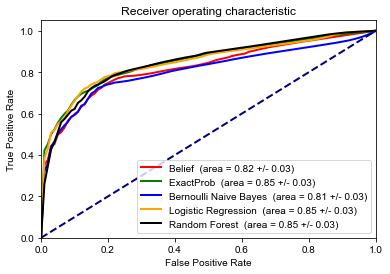

In [42]:
res_unweighted = eval_models_relation(models_rel, bin_df, reader_list, train_test_split,
                                      test_split=0.2, num_folds=10,
                                      cols_to_include=reader_list + ['correct'])
plot_roc(res_unweighted)

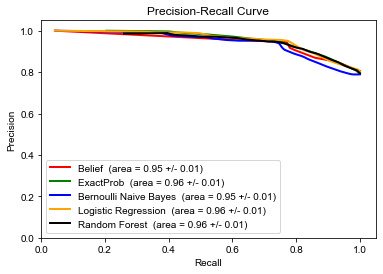

In [43]:
plot_prc(res_unweighted)

In [44]:
unwt_probs_df = compare_probs(models_rel, reader_list, reader_abbrevs, cur_freq_df, 'Curation Freq.')
unwt_probs_df

,Belief,ExactProb,Bernoulli Naive Bayes,Logistic Regression,Random Forest,Curation Freq.
Readers,,,,,,
"(R, _, _, _, _)",0.866883,0.502959,0.491399,0.570373,0.527749,0.156048
"(R, S, M, _, T)",0.999906,0.993464,0.989432,0.989403,0.991808,0.141274
"(R, _, M, _, _)",0.988399,0.936842,0.817863,0.881789,0.919928,0.087719
"(_, _, M, _, _)",0.912854,0.569767,0.575927,0.626061,0.616870,0.079409
"(R, S, M, _, _)",0.999040,1.000000,0.967681,0.957662,1.000000,0.061865
"(R, S, _, _, _)",0.988983,0.892308,0.865633,0.801021,0.900714,0.060018
"(_, _, _, _, T)",0.901840,0.655738,0.477463,0.551558,0.638067,0.056325
"(_, _, _, P, _)",0.908046,0.666667,0.441075,0.626154,0.608051,0.044321
"(R, S, _, P, _)",0.998987,0.947368,0.945646,0.957678,0.969985,0.035088


In [45]:
unwt_probs_df.corr('pearson')

,Belief,ExactProb,Bernoulli Naive Bayes,Logistic Regression,Random Forest,Curation Freq.
Belief,1.000000,0.858653,0.699140,0.746433,0.474542,-0.536887
ExactProb,0.858653,1.000000,0.777509,0.911566,0.963184,-0.372004
Bernoulli Naive Bayes,0.699140,0.777509,1.000000,0.925660,0.819699,-0.349816
Logistic Regression,0.746433,0.911566,0.925660,1.000000,0.872172,-0.381604
Random Forest,0.474542,0.963184,0.819699,0.872172,1.000000,-0.316589
Curation Freq.,-0.536887,-0.372004,-0.349816,-0.381604,-0.316589,1.000000


#### Weighted

 20%|██        | 2/10 [00:00<00:00, 19.98it/s]

['reach', 'sparser', 'medscan', 'rlimsp', 'trips', 'correct']


100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


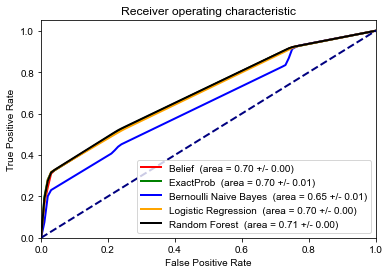

In [46]:
res_weighted = eval_models_relation(models_rel, resampled_df, reader_list, train_test_split,
                                    test_split=0.2, num_folds=10)
plot_roc(res_weighted)

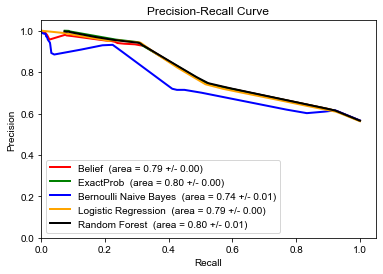

In [47]:
plot_prc(res_weighted)

In [48]:
wt_probs_df = compare_probs(models_rel, reader_list, reader_abbrevs, stmt_freq_df, 'Corpus Freq.')
wt_probs_df

,Belief,ExactProb,Bernoulli Naive Bayes,Logistic Regression,Random Forest,Corpus Freq.
Readers,,,,,,
"(R, _, _, _, _)",0.625623,0.505334,0.548892,0.503633,0.508744,0.449950
"(_, _, M, _, _)",0.713712,0.561209,0.622558,0.557107,0.557434,0.201791
"(_, S, _, _, _)",0.556681,0.292984,0.380757,0.310300,0.290334,0.153938
"(R, _, M, _, _)",0.892820,0.935484,0.757505,0.952007,0.938259,0.078537
"(R, S, _, _, _)",0.834031,0.905749,0.537999,0.876464,0.905013,0.049878
"(R, S, M, _, _)",0.952485,1.000000,0.749349,0.992842,1.000000,0.028466
"(_, S, M, _, _)",0.873083,1.000000,0.612188,0.897914,1.000000,0.010037
"(R, S, M, _, T)",0.993780,0.986928,0.944643,0.999408,0.991662,0.005133
"(_, _, _, _, T)",0.869099,0.674242,0.785739,0.439277,0.673046,0.004401


In [49]:
wt_probs_df.corr('spearman')

,Belief,ExactProb,Bernoulli Naive Bayes,Logistic Regression,Random Forest,Corpus Freq.
Belief,1.000000,0.721806,0.945015,0.950513,0.570206,-0.744355
ExactProb,0.721806,1.000000,0.601582,0.752442,0.882810,-0.638717
Bernoulli Naive Bayes,0.945015,0.601582,1.000000,0.832478,0.402487,-0.836694
Logistic Regression,0.950513,0.752442,0.832478,1.000000,0.676045,-0.617339
Random Forest,0.570206,0.882810,0.402487,0.676045,1.000000,-0.353205
Corpus Freq.,-0.744355,-0.638717,-0.836694,-0.617339,-0.353205,1.000000


#### Uniform

 20%|██        | 2/10 [00:00<00:00, 17.96it/s]

['reach', 'sparser', 'medscan', 'rlimsp', 'trips', 'correct']


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


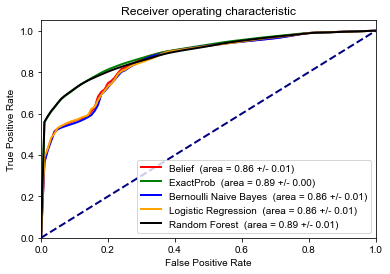

In [50]:
uniform_df = resample_curation_data(reader_freqs, curation_freqs, curation_dfs,
                                      tgt_size=30000, sampling='uniform')

res_uniform = eval_models_relation(models_rel, uniform_df, reader_list, train_test_split,
                                   test_split=0.2, num_folds=10)
plot_roc(res_uniform)

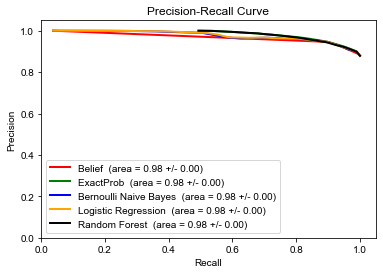

In [51]:
plot_prc(res_uniform)

In [52]:
uni_probs_df = compare_probs(models_rel, reader_list, reader_abbrevs, stmt_freq_df, 'ExactProb')
uni_probs_df

,Belief,ExactProb,Bernoulli Naive Bayes,Logistic Regression,Random Forest,Corpus Freq.
Readers,,,,,,
"(R, S, M, P, T)",0.999999,1.000,0.994832,0.999468,1.000000,0.000509
"(_, S, _, P, _)",0.996052,1.000,0.895633,0.901636,1.000000,0.000984
"(R, _, M, P, _)",0.999790,1.000,0.973290,0.988293,1.000000,0.000150
"(R, _, _, P, T)",0.999739,1.000,0.961654,0.983727,1.000000,0.000051
"(_, S, M, P, T)",0.999982,1.000,0.986297,0.997255,1.000000,0.000045
"(_, S, M, P, _)",0.999763,1.000,0.967698,0.985548,1.000000,0.000245
"(_, S, M, _, _)",0.995112,1.000,0.860158,0.863351,1.000000,0.010037
"(_, S, _, P, T)",0.999705,1.000,0.953743,0.979933,1.000000,0.000193
"(R, _, M, P, T)",0.999984,1.000,0.988707,0.997781,1.000000,0.000030


In [53]:
uni_probs_df.corr('pearson')

,Belief,ExactProb,Bernoulli Naive Bayes,Logistic Regression,Random Forest,Corpus Freq.
Belief,1.000000,0.904647,0.715097,0.727588,0.480715,-0.676793
ExactProb,0.904647,1.000000,0.895054,0.920035,0.999758,-0.626400
Bernoulli Naive Bayes,0.715097,0.895054,1.000000,0.988981,0.879973,-0.618353
Logistic Regression,0.727588,0.920035,0.988981,1.000000,0.895762,-0.675273
Random Forest,0.480715,0.999758,0.879973,0.895762,1.000000,-0.620332
Corpus Freq.,-0.676793,-0.626400,-0.618353,-0.675273,-0.620332,1.000000


### Comparison of approaches to predict correctness at the mention level

In [49]:
class BeliefModel(object):
    def __init__(self, reader_list, model_class=None, nwalkers=100,
                  burn_steps=100, sample_steps=100):
        if model_class is None:
            model_class = OrigBeliefStmt
        self.reader_list = reader_list
        self.model_class = model_class
        self.nwalkers = nwalkers
        self.burn_steps = burn_steps
        self.sample_steps = sample_steps
        self.reader_results = {}

    @staticmethod
    def df_to_num_ev(df):
        d = {}
        for _, num_ev, correct in df.itertuples():
            if num_ev not in d:
                d[num_ev] = []
            d[num_ev].append(correct)
        return d

    def fit(self, x_train, y_train, y_target=1):
        data = np.column_stack([x_train, y_train])
        self.y_ix = data.shape[1]-1
        self.y_target = y_target
        cols = self.reader_list + ['correct']
        df = pd.DataFrame(data, columns=cols)
        # Get the unique input vectors in x_train
        for reader in self.reader_list:
            r_df = df[df[reader] > 0][[reader, 'correct']]
            correct_by_num_ev = self.df_to_num_ev(r_df)
            # Convert the dataframe into a dictionary of corrects and incorrects keyed
            # by numbers of evidences
            print(reader, r_df.shape)
            model = OrigBeliefStmt()
            mf = ModelFit(model, correct_by_num_ev)
            with Pool() as pool:
                sampler = ens_sample(mf, self.nwalkers, self.burn_steps,
                                     self.sample_steps, pool=pool)
            self.reader_results[reader] = (mf, sampler)

    def predict_proba(self, x_arr):           
        y_probs = np.zeros((x_arr.shape[0], 2))
        reader_errs = np.zeros((x_arr.shape[0], len(reader_list)))
        for ix, reader in enumerate(self.reader_list):
            x_data = x_arr[:, ix]
            mf, sampler = self.reader_results[reader]
            map_params_dict = mf.get_map_params(sampler)
            params = [map_params_dict[pname] for pname in mf.model.param_names]
            reader_errs[:, ix] = mf.model.stmt_predictions(params, x_data)
        err_probs = 1 - reader_errs
        y_probs[:, 0] = err_probs.prod(axis=1)
        y_probs[:, 1] = 1 - y_probs[:, 0]
        return y_probs
    
    def predict(self, x_arr, threshold=0.5):
        y_preds = np.zeros(x_arr.shape[0])
        y_probs = self.predict_proba(x_arr)
        for row_ix, pred_prob in enumerate(y_probs):
            if pred_prob[1] is np.nan:
                pred = np.nan
            else:
                pred = 0 if pred_prob[1] < threshold else 1
            y_preds[row_ix] = pred
        return y_preds

In [50]:
class BeliefBayesModel(object):
    def __init__(self, df, ev_ub, reader_list, model_class=None, nwalkers=100,
                  burn_steps=100, sample_steps=100):
        if model_class is None:
            model_class = OrigBeliefStmt
        self.reader_list = reader_list
        self.model_class = model_class
        self.nwalkers = nwalkers
        self.burn_steps = burn_steps
        self.sample_steps = sample_steps
        self.reader_results = {}
        self.all_data = df
        self.ev_ub = ev_ub
        self.p_ri = {}
        self.p_ri_rj = {}
        self.p_c_r0 = {}
        
    @staticmethod
    def df_to_num_ev(df):
        d = {}
        for _, num_ev, correct in df.itertuples():
            if num_ev not in d:
                d[num_ev] = []
            d[num_ev].append(correct)
        return d

    def fit(self, x_train, y_train, y_target=1):
        data = np.column_stack([x_train, y_train])
        self.y_ix = data.shape[1]-1
        self.y_target = y_target
        cols = self.reader_list + ['correct']
        df = pd.DataFrame(data, columns=cols)
        # Run MCMC for each reader
        for reader in self.reader_list:
            r_df = df[df[reader] > 0][[reader, 'correct']]
            correct_by_num_ev = self.df_to_num_ev(r_df)
            # Convert the dataframe into a dictionary of corrects and incorrects keyed
            # by numbers of evidences
            print(reader, r_df.shape)
            model = OrigBeliefStmt()
            mf = ModelFit(model, correct_by_num_ev)
            with Pool() as pool:
                sampler = ens_sample(mf, self.nwalkers, self.burn_steps,
                                     self.sample_steps, pool=pool)
            self.reader_results[reader] = (mf, sampler)
        # Calculate p_correct from the training data only
        self.p_correct = np.mean(y_train)
        # Calculate p_c_r0
        for reader in self.reader_list:
            """
            # In principle this could be calculated given a model and 
            # an estimate of p(correct)
            mf, sampler = self.reader_results[reader]
            map_params_dict = mf.get_map_params(sampler)
            params = [map_params_dict[pname] for pname in mf.model.param_names]
            mf.model.stmt_predictions(params, x_data)
            for rd_ct, rd_ct_df in self.all_data.groupby(reader):
                if rd_ct == 0:
                    continue
            """
            self.p_c_r0[reader] = prob([('correct', 1)], [(reader, 0)], df=df)
        # Calculate reader marginal probabilities using all data
        n = len(self.all_data)
        for reader in reader_list:
            self.p_ri[reader] = {}
            for rd_ev, rd_ev_df in self.all_data.groupby(reader)[reader]:
                rd_ev_ct = rd_ev_df.count()
                self.p_ri[reader][rd_ev] = rd_ev_ct / n
        # Reader joint probabilities using all data
        for rd_cts, rd_df in self.all_data.groupby(self.reader_list)[reader_list]:
            self.p_ri_rj[rd_cts] = len(rd_df) / n

    def predict_proba(self, x_arr):           
        y_probs = np.zeros((x_arr.shape[0], 2))
        p_ri_c = np.zeros((x_arr.shape[0], len(reader_list)))
        p_c_ri = np.zeros((x_arr.shape[0], len(reader_list)))

        coeffs = np.zeros(x_arr.shape[0])
        # For each row, we need p(c) / p(R1,...,Rn)
        for i in range(x_arr.shape[0]):
            x_row = x_arr[i, :]
            joint_prob = self.p_ri_rj[tuple(x_row)]
            coeffs[i] = joint_prob
        coeffs = self.p_correct / coeffs
        # For each row, we need conditionally indep. estimates of p(c|Ri)
        for ix, reader in enumerate(self.reader_list):
            x_data = x_arr[:, ix]
            mf, sampler = self.reader_results[reader]
            map_params_dict = mf.get_map_params(sampler)
            params = [map_params_dict[pname] for pname in mf.model.param_names]
            p_c_ri[:, ix] = mf.model.stmt_predictions(params, x_data)
            p_c_ri[x_data == 0] = self.p_c_r0[reader]
        # For each row, we need p(Ri=ri) / p(c) for each reader
        for i in range(x_arr.shape[0]):
            for j, reader in enumerate(self.reader_list):
                p_ri_c[i, j] = self.p_ri[reader][x_arr[i, j]]
        p_ri_c = p_ri_c / self.p_correct
        p_ri_c = p_ri_c * p_c_ri
        probs = p_ri_c.prod(axis=1) * coeffs        
        #err_probs = 1 - reader_errs
        y_probs[:, 1] = probs
        y_probs[:, 0] = 1 - y_probs[:, 1]
        return y_probs
    
    def predict(self, x_arr, threshold=0.5):
        y_preds = np.zeros(x_arr.shape[0])
        y_probs = self.predict_proba(x_arr)
        for row_ix, pred_prob in enumerate(y_probs):
            if pred_prob[1] is np.nan:
                pred = np.nan
            else:
                pred = 0 if pred_prob[1] < threshold else 1
            y_preds[row_ix] = pred
        return y_preds

In [51]:

    
class BinaryRandomForest(RandomForestClassifier):
    @staticmethod
    def _binarize(x_arr):
        bin_arr = x_arr.copy()
        bin_arr[bin_arr > 0] = 1
        return bin_arr
        
    def fit(self, x_train, y_train, *args, **kwargs):
        return super().fit(self._binarize(x_train), y_train, *args, **kwargs)
    
    def predict(self, x_arr, *args, **kwargs):
        return super().predict(self._binarize(x_arr), *args, **kwargs)
    
    def predict_proba(self, x_arr, *args, **kwargs):
        return super().predict_proba(self._binarize(x_arr), *args, **kwargs)

In [52]:
def split_by_ev_ct(x_data, y_data, reader_list, low_ub=1, num_low=10, high_lb=8, num_high=10, test_size=None):
    data = np.column_stack([x_data, y_data])
    cols = reader_list + ['correct']
    df = pd.DataFrame(data, columns=cols)
    df_list = []
    for rdr in reader_list:
        # Get the row with evidence for this reader
        low_ev_rows = df[(df[rdr] > 0) & (df[rdr] <= low_ub)]
        high_ev_rows = df[df[rdr] > high_lb]
        low_samp = low_ev_rows.sample(num_low, replace=True)
        high_samp = high_ev_rows.sample(num_high, replace=True)
        df_list.extend([low_samp, high_samp])
    train_df = pd.concat(df_list).drop_duplicates()
    test_df = df[~df.index.isin(train_df.index)]
    x_train = train_df[reader_list].values
    y_train = train_df['correct'].values
    x_test = test_df[reader_list].values
    y_test = test_df['correct'].values
    return x_train, x_test, y_train, y_test

def split_closure(x_data, y_data, test_size):
    return split_by_ev_ct(x_data, y_data, reader_list, low_ub=1, num_low=5,
                          high_lb=8, num_high=5, test_size=test_size)

In [53]:
def plot_aurocs(clf_aurocs, xticks, xticklabels, title, xlabel):
    plt.figure()
    for clf_name, aurocs in clf_aurocs.items():
        plt.errorbar(xticks, aurocs['mean'], yerr=aurocs['sd'], label=clf_name, marker='.')
    plt.legend(loc="lower right")
    plt.ylabel('AUROC')
    plt.title(title)
    plt.xticks(xticks)
    plt.xlabel(xlabel)
    ax = plt.gca()
    ax.set_xticklabels(xticklabels)
    plt.show()
    
def plot_auprcs(clf_auprcs, xticks, xticklabels, title, xlabel):
    plt.figure()
    for clf_name, auprcs in clf_auprcs.items():
        plt.errorbar(xticks, auprcs['mean'], yerr=auprcs['sd'], label=clf_name, marker='.')
    plt.legend(loc="lower right")
    plt.ylabel('AUPRC')
    plt.title(title)
    plt.xticks(xticks)
    plt.xlabel(xlabel)
    ax = plt.gca()
    ax.set_xticklabels(xticklabels)
    plt.show()

In [171]:
reader_list

['reach', 'sparser', 'medscan', 'rlimsp', 'trips']

In [54]:
# ROC and PRC comparison for different models, using all data
#train_df = kge_df[reader_list + ['correct']]
models_ev = {
    'Logistic Regression': LogisticRegression(),
    'Log-Logistic Regression': LogLogisticRegression(),    
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
    #'Random Forest': RandomForestClassifier(),
    'Binary Random Forest n1000d4': BinaryRandomForest(n_estimators=1000, max_depth=4),
    'Binary Random Forest': BinaryRandomForest(),
    'Binary Random Forest n1000': BinaryRandomForest(n_estimators=1000)
    #'Belief Orig': BeliefModel(reader_list),
    #'Belief Binomial': BeliefModel(reader_subset, model_class=BinomialStmt),
    #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
    #                           nwalkers=100, burn_steps=100, sample_steps=100)
    #'GaussianNB': GaussianNB(),
}

res_ev = eval_models_relation(models_ev, kge_df, reader_list, train_test_split,
                              test_split=0.2, num_folds=10, cols_to_include=None)

  0%|          | 0/10 [00:00<?, ?it/s]

['reach', 'sparser', 'medscan', 'rlimsp', 'trips', 'correct']


100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


<IPython.core.display.Javascript object>


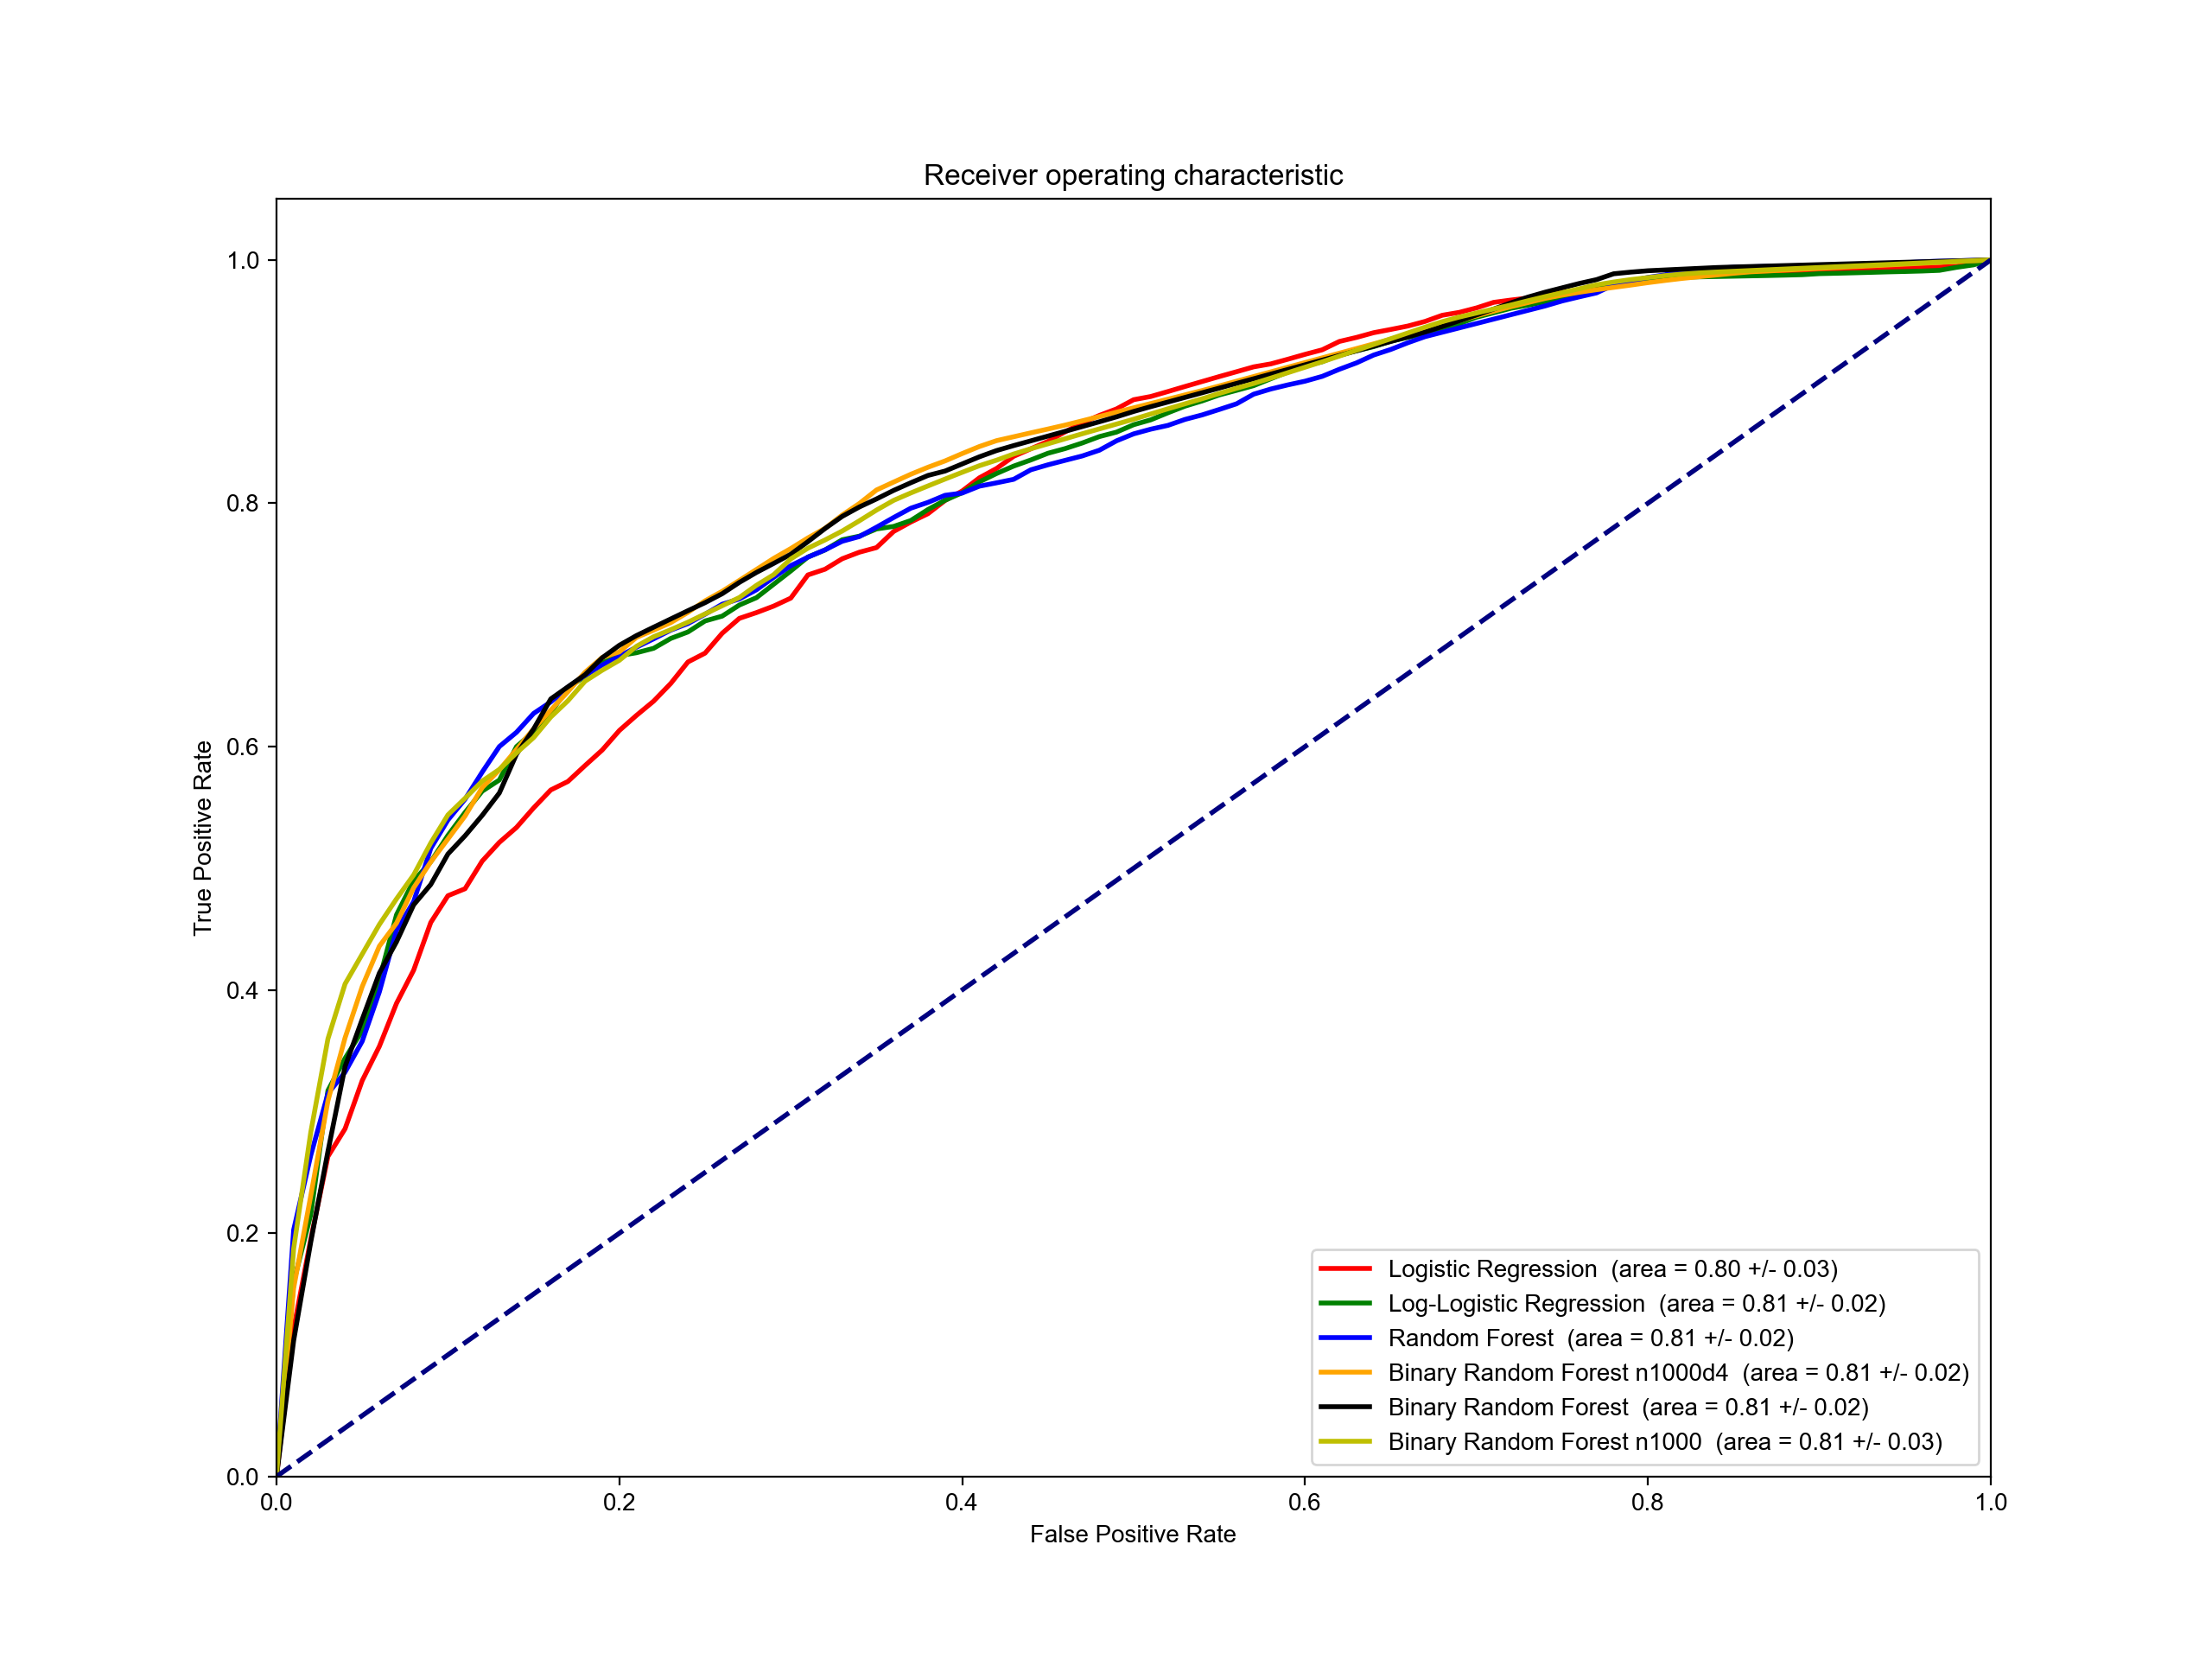

In [55]:
plot_roc(res_ev)

<IPython.core.display.Javascript object>


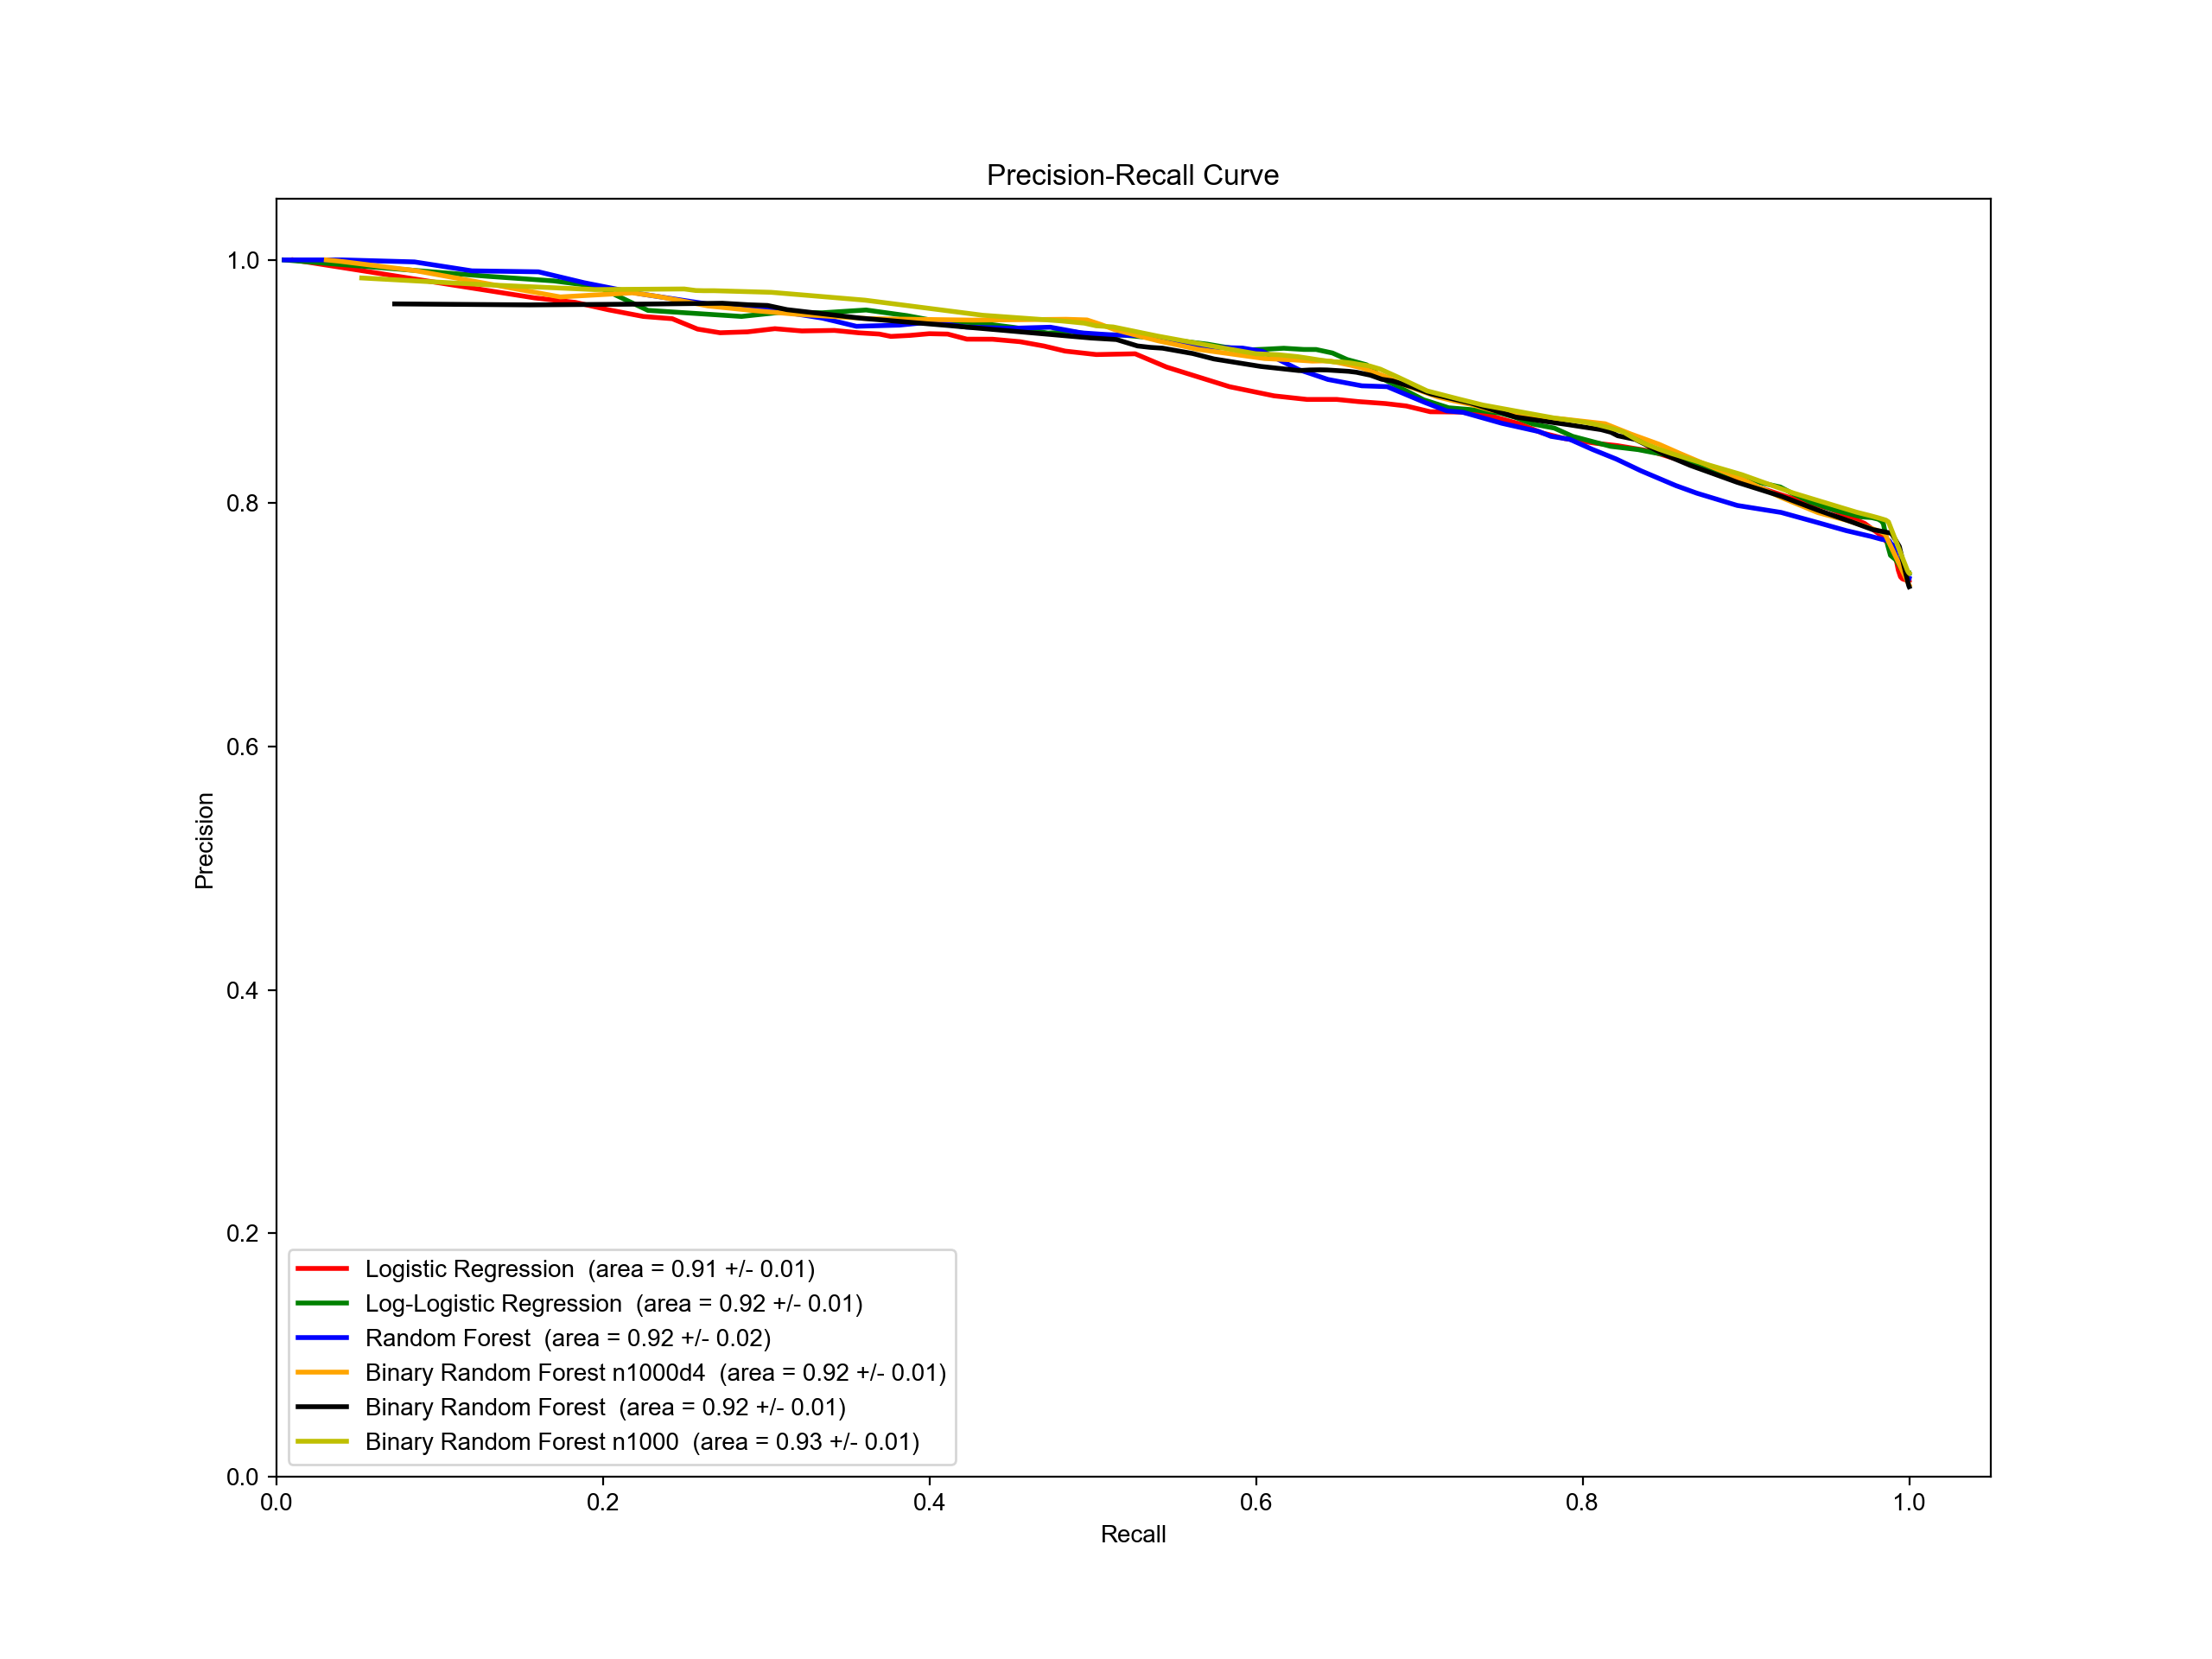

In [56]:
plot_prc(res_ev)

Save the Binary Random Forest model:

In [ ]:
brf_model = models_ev['Binary Random Forest n1000']
with open('../output/trained_random_forest.pkl', 'wb') as f:
    pickle.dump(brf_model, f)

In [57]:
llr_model = models_ev['Log-Logistic Regression']
with open('../output/trained_loglogreg.pkl', 'wb') as f:
    pickle.dump(llr_model, f)

In [59]:
reader_list

['reach', 'sparser', 'medscan', 'rlimsp', 'trips']

Now we give the dataset with supplementary evidences as well:

In [ ]:
supp_df.columns

In [ ]:
# ROC and PRC comparison for different models, using all data
#train_df = kge_df[reader_list + ['correct']]
models_ev = {
    'Logistic Regression': LogisticRegression(),
    'Log-Logistic Regression': LogLogisticRegression(),    
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
    #'Random Forest': RandomForestClassifier(),
    'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
    #'Belief Orig': BeliefModel(reader_list),
    #'Belief Binomial': BeliefModel(reader_subset, model_class=BinomialStmt),
    #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
    #                           nwalkers=100, burn_steps=100, sample_steps=100)
    #'GaussianNB': GaussianNB(),
}

res_ev = eval_models_relation(models_ev, supp_df, reader_list, train_test_split,
                              test_split=0.2, num_folds=10,
                              cols_to_include=reader_list + ['num_supports', 'stmt_type', 'correct'])

In [ ]:
plot_roc(res_ev)

In [ ]:
plot_prc(res_ev)

Now we give the other classifiers the statement type and agA/B namespaces as attributes:

In [ ]:
# ROC and PRC comparison for different models, using all data
#train_df = kge_df[reader_list + ['correct']]
models_ev = {
    'Logistic Regression': LogisticRegression(),
    'Log-Logistic Regression': LogLogisticRegression(),    
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
    #'Random Forest': RandomForestClassifier(),
    'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=6),
    #'Belief Orig': BeliefModel(reader_list),
    #'Belief Binomial': BeliefModel(reader_subset, model_class=BinomialStmt),
    #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
    #                           nwalkers=100, burn_steps=100, sample_steps=100)
    #'GaussianNB': GaussianNB(),
}

res_ev = eval_models_relation(models_ev, kge_df, reader_list, train_test_split,
                              test_split=0.2, num_folds=10,
                              cols_to_include=reader_list + ['stmt_type', 'agA_ns', 'agB_ns', 'correct'])

In [ ]:
plot_roc(res_ev)

In [ ]:
plot_prc(res_ev)

In [ ]:
def adding_readers(reader_list, df, num_folds=10):
    clf_aurocs = {}
    clf_auprcs = {}
    for i in range(1, len(reader_list) + 1):
        reader_subset = reader_list[0:i]
        train_df = df[reader_subset + ['correct']]
        models_ev = {
            'Logistic Regression': LogisticRegression(),
            'Log-Logistic Regression': LogLogisticRegression(),    
            'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
            #'Random Forest': RandomForestClassifier(),
            'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
            'Belief': BeliefModel(reader_subset),
            #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
            #                           nwalkers=100, burn_steps=100, sample_steps=100)
            #'GaussianNB': GaussianNB(),
        }
        
        res_ev = eval_models_relation(models_ev, train_df, reader_subset, train_test_split,
                                  test_split=0.2, num_folds=num_folds)
        roc_auc = res_ev['roc_auc']
        pr_auc = res_ev['pr_auc']
        for i, (clf_name, roc_auc_arr) in enumerate(roc_auc.items()):
            pr_auc_arr = pr_auc[clf_name]
            if clf_name not in clf_aurocs:
                clf_aurocs[clf_name] = {'mean': [], 'sd': []}
            clf_aurocs[clf_name]['mean'].append(roc_auc_arr.mean())
            clf_aurocs[clf_name]['sd'].append(roc_auc_arr.std())
            if clf_name not in clf_auprcs:
                clf_auprcs[clf_name] = {'mean': [], 'sd': []}
            clf_auprcs[clf_name]['mean'].append(pr_auc_arr.mean())
            clf_auprcs[clf_name]['sd'].append(pr_auc_arr.std())
    return (clf_aurocs, clf_auprcs)

In [ ]:
def adding_data(num_low_high, reader_list, df, num_folds=10):
    clf_aurocs = {}
    clf_auprcs = {}
    
    for i, (num_low, num_high) in enumerate(num_low_high):
        train_df = df[reader_list + ['correct']]
        
        def split_closure(x_data, y_data, test_size):
            return split_by_ev_ct(x_data, y_data, reader_list, low_ub=1, num_low=num_low,
                                  high_lb=8, num_high=num_high, test_size=test_size)
        
        models_ev = {
            'Logistic Regression': LogisticRegression(),
            'Log-Logistic Regression': LogLogisticRegression(),    
            #'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
            #'Random Forest': RandomForestClassifier(),
            #'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
            'Belief': BeliefModel(reader_subset),
            #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
            #                           nwalkers=100, burn_steps=100, sample_steps=100)
            #'GaussianNB': GaussianNB(),
        }
        res_ev = eval_models_relation(models_ev, train_df, reader_subset, split_closure,
                                      test_split=0.2, num_folds=num_folds)
        roc_auc = res_ev['roc_auc']
        pr_auc = res_ev['pr_auc']
        for i, (clf_name, roc_auc_arr) in enumerate(roc_auc.items()):
            pr_auc_arr = pr_auc[clf_name]
            if clf_name not in clf_aurocs:
                clf_aurocs[clf_name] = {'mean': [], 'sd': []}
            clf_aurocs[clf_name]['mean'].append(roc_auc_arr.mean())
            clf_aurocs[clf_name]['sd'].append(roc_auc_arr.std())
            if clf_name not in clf_auprcs:
                clf_auprcs[clf_name] = {'mean': [], 'sd': []}
            clf_auprcs[clf_name]['mean'].append(pr_auc_arr.mean())
            clf_auprcs[clf_name]['sd'].append(pr_auc_arr.std())
    return (clf_aurocs, clf_auprcs)

In [ ]:
#num_low_high = [(3, 3), (5, 5), (8, 8), (12, 12), (17, 17), (25, 25), (100, 100), (1000, 1000)]
num_low_high = [(5, 5), (10, 10), (20, 20), (30, 30)]
ad_rocs, ad_prcs = adding_data(num_low_high, reader_list, kge_df, num_folds=10)

In [ ]:
plot_aurocs(ad_rocs, list(range(len(num_low_high))), [t[0] for t in num_low_high],
            'Classifier AUROC with increasing data', 'Bin sample size')
plot_auprcs(ad_prcs, list(range(len(num_low_high))), [t[0] for t in num_low_high],
            'Classifier AUROC with increasing data', 'Bin sample size')


In [ ]:
plot_aurocs(clf_aurocs, list(range(len(reader_list))), reader_list,
            'Classifier AUROC with increasing readers', 'Reader added')
plot_auprcs(clf_auprcs, list(range(len(reader_list))), reader_list,
           'Classifier AUPRC with increasing readers', 'Reader added')

In [ ]:
reader_subset = reader_list
#reader_subset = ['reach', 'sparser', 'medscan']
train_df = kge_df[reader_subset + ['correct']]

models_ev = {
    'Logistic Regression': LogisticRegression(),
    'Log-Logistic Regression': LogLogisticRegression(),    
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
    #'Random Forest': RandomForestClassifier(),
    'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
    #'Belief': BeliefModel(reader_subset),
    #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
    #                           nwalkers=100, burn_steps=100, sample_steps=100)
    'GaussianNB': GaussianNB(),
}

res_ev = eval_models_relation(models_ev, train_df, reader_subset, train_test_split,
                              test_split=0.2, num_folds=10)

In [ ]:
plot_roc(res_ev)

In [ ]:
plot_prc(res_ev)

In [ ]:
df = train_df
# Get exact probability for reach 1, sparser 2
cond_df = df[(df.reach == 1) & (df.sparser == 1) & (df.medscan == 0) & (df.rlimsp == 0) & (df.trips == 0)]
corr_df = cond_df[cond_df.correct == 1]
len(corr_df) / len(cond_df)

In [ ]:
# Get exact probability of p(R1...Rn|c)
df = train_df
corr_df = df[df.correct == 1]
cond_df = corr_df[(corr_df.reach == 1) & (corr_df.sparser == 1) & (corr_df.medscan == 0) & 
                  (corr_df.rlimsp == 0) & (corr_df.trips == 0)]
p_ri_rj_c = len(cond_df) / len(corr_df)
p_ri_rj_c

In [ ]:
coeff = bbm.p_correct / bbm.p_ri_rj[tuple(example[0])]
coeff

In [ ]:
coeff * p_ri_rj_c

In [ ]:
prod = coeff
exact = coeff
for i, (reader, val) in enumerate(zip(reader_list, example[0])):
    if val == 0:
        pass
    mf, sampler = bbm.reader_results[reader]
    map_params_dict = mf.get_map_params(sampler)
    params = [map_params_dict[pname] for pname in mf.model.param_names]
    p_c_ri = mf.model.stmt_predictions(params, [val])[0]
    if val == 0:
        p_c_ri = bbm.p_c_r0[reader]
    p_ri = bbm.p_ri[reader][val]
    print(reader)
    print("p_ri", p_ri)
    print("p_c_ri", p_c_ri)
    print()
    prod *= (p_c_ri * p_ri) / bbm.p_correct
    
    corr_df = train_df[train_df.correct == 1]
    ri_df = corr_df[corr_df[reader] == val]
    p_ri_c = len(ri_df) / len(corr_df)
    exact *= p_ri_c
print(prod)
print(exact)

In [ ]:
reader_subset = ['reach', 'medscan']
reader_subset = reader_list

models_ev = {
    'Logistic Regression': LogisticRegression(),
    'Log-Logistic Regression': LogLogisticRegression(),    
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
    #'Random Forest': RandomForestClassifier(),
    'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
    #'Belief': BeliefModel(reader_subset)
}

train_df = kge_df[reader_subset + ['correct']]
res_ev = eval_models_relation(models_ev, train_df, reader_subset, train_test_split,
                              test_split=0.2, num_folds=10)

plot_roc(res_ev)

In [ ]:
reader_subset = reader_list

def split_closure(x_data, y_data, test_size):
    return split_by_ev_ct(x_data, y_data, reader_subset, low_ub=1, num_low=5,
                          high_lb=8, num_high=5, test_size=test_size)

models_ev = {
    'Logistic Regression': LogisticRegression(),
    'Log-Logistic Regression': LogLogisticRegression(),    
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
    #'Random Forest': RandomForestClassifier(),
    'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
    'Belief': BeliefModel(reader_subset)
}

train_df = kge_df[reader_subset + ['correct']]
res_ev = eval_models_relation(models_ev, train_df, reader_subset, split_closure, num_folds=10)

plot_roc(res_ev)

In [ ]:
#plt.figure()
#x_vals = kge_df[kge_df['reach'] > 0]['reach'].values
#plt.hist(x_vals)
df = kge_df.copy()
x_vals = []
y_vals = []
for ct, ct_df in df.groupby('reach'):
    x_vals.append(ct)
    y_vals.append(len(ct_df))
x_vals = np.array(x_vals)
y_vals = np.array(y_vals)
plt.figure()
plt.plot(np.log10(x_vals + 1), np.log10(y_vals + 1))

### Properties of belief scores under different assumptions

To illustrate the properties of belief scores under different assumptions about reader performance and dependence, we generated simulated data using the following approach. We imagine a space of $(relation,sentence)$ combinations defined for a defined text corpus and set of relation types, and over this space, with overall size $n$, we have a baseline probability, prior to the consideration of any reading systems, of a particular $(relation_i,sentence_j)$ being correct, denoted $p(corr)$. Then, for each reader, we define the recall and false discovery rate (FDR) as follows:

$$R_i^{re} = p(R_i=1|corr=1) = \frac{TP}{FN + TP}$$

$$R_i^{fdr} = p(corr=1|R_i=1) = \frac{FP}{TP + FP}$$

where TP, TN, FP, and FN denote the true positives, true negatives, false positives, and false negatives, respectively. We note that $p(corr) = \frac{TP + FN}{n}$. Then given the four parameters $n$, $p(corr)$, $R_i^{re}$, and $R_i^{fdr}$, we calculate TP, TN, FP, and FN for each reader $R_i$ as follows:

$$TP_i = R_i^{re} \cdot p(corr) \cdot n$$

$$FP_i = \frac{TP_i \cdot R_i^{fdr}}{1 - R_i^{fdr}}$$

$$FN_i = p(corr) \cdot n - TP_i$$

$$TN_i = p(corr) \cdot n - TP_i - FP_i - TN_i$$


Imagine subsets of these statements that have a higher likelihood of extraction by both readers, e.g., the high frequency ones.

Imagine a base number, e.g. of sentences. R1 generates a correct or incorrect. R2 generates a correct or incorrect.

In [ ]:
# Simulator of reader data (incomplete)
class Simulator(object):
    def __init__(self, p_correct, base_n, reader_params):
        """Simulation distribution of reader output and correctness.
        
        Parameters
        ----------
        p_correct : float
            Baseline probability of correctness for a given (relation, sentence).
        base_n : int
            The size of the overall (relation, sentence) event space.
        reader_params: dict
            Dictionary of reader precision and recall values. Keys denote
            reader names, values are tuples of floats (fdr, recall).
        """
        self.p_correct = p_correct
        self.base_n = base_n
        self.reader_params = reader_params 
        self.reader_counts = {}
    
    def simulate(self):
        event_space = np.random.choice([0, 1], size=self.base_n,
                                       p=[1-self.p_correct, self.p_correct])
        self.num_correct = event_space.sum()
        df = pd.DataFrame(event_space, columns=['correct'])
        for r_name, (fdr, rec) in self.reader_params.items():
            tp = rec * self.num_correct
            fp = (fdr * tp) / (1 - fdr)
            #fp = fp_rate * (self.base_n - self.num_correct)
            fn = self.num_correct - tp
            tn = self.base_n - tp - fp - fn
            #print("Num correct", self.num_correct)
            #print(tp, fp, fn, tn, self.base_n)
            #print("Total", tp+tn+fp+fn)
            self.reader_counts[r_name] = {'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}
            # Get a vector of R and ~R of length num_correct
            corr_arr = np.random.choice([0, 1], size=self.num_correct,
                                        p=(1-rec, rec))
            inc_arr = np.random.choice([0, 1], size=self.base_n - self.num_correct,
                                       p=(1 - fp/(fp+tn), fp/(fp+tn)))
            # Assign to the subspace of correct statements
            df.loc[df['correct']==1, r_name] = corr_arr            
            df.loc[df['correct']==0, r_name] = inc_arr
        df = df.astype('int')
        reader_names = list(self.reader_params.keys())
        filt_df = df[df[reader_names].any(1)]
        return filt_df, df

    def summarize(self, df):
        r_names = [col for col in df.columns if col != 'correct']
        p_corr = prob([('correct', 1)], df=df)
        abs_p_corr = self.p_correct
        reader_mat = []
        cond_probs = [f'p(ri=1|{r}=1)' for r in r_names]
        index = ['Abs Recall', 'Abs FDR', 'Precision', 'Recall', 'FDR',
                 'Abs p(corr)', 'p(corr)', 'p(ri)'] + cond_probs
        for reader_i in r_names:
            rec_param = self.reader_params[reader_i][1]
            fdr_param = self.reader_params[reader_i][0]
            prec = prob([('correct', 1)], [(reader_i, 1)], df)
            recall = prob([(reader_i, 1)], [('correct', 1)], df)
            fdr = prob([('correct', 0)], [(reader_i, 1)], df)
            p_r = prob([(reader_i, 1)], df=df)
            reader_data = [rec_param, fdr_param, prec, recall, fdr, abs_p_corr, p_corr, p_r]
            for reader_j in r_names:
                cond_prob = prob([(reader_i, 1)], [(reader_j, 1)], df)
                reader_data.append(cond_prob)
            reader_mat.append(reader_data)
        # Transpose the list of lists
        reader_mat = list(map(list, zip(*reader_mat)))
        return pd.DataFrame(reader_mat, index=index, columns=r_names)
    
    def joint_probs(self, df):
        r_abbrevs = {r: r for r in df.columns}
        col_list = [r for r in df.columns]
        freq_dict, _ = get_reader_freq_from_curation(df, col_list, r_abbrevs)
        return make_df(freq_dict, 'Readers', 'Exact')
    
    def corr_probs(self, df):
        r_names = [col for col in df.columns if col != 'correct']
        cp_dict = {} # Conditional probability dictionary
        # Get precision estimates for each reader
        err_dict = {}
        belief_dict = {}
        for reader in r_names:
            err_dict[reader] = prob([('correct', 0)], [(reader, 1)], df)
        for r_obs_list in itertools.product([0, 1], repeat=len(r_names)):
            c_prob = []
            label = []
            err_prob = 1
            for i, r_name in enumerate(r_names):
                if r_obs_list[i]:
                    label.append(r_name)
                    c_prob.append((r_name, 1))
                    err_prob *= err_dict[r_name]
                else:
                    label.append('_')
                    c_prob.append((r_name, 0))
            cp_dict[tuple(label)] = prob([('correct', 1)], c_prob, df)
            belief_dict[tuple(label)] = 1 - err_prob
        df_prob = make_df(cp_dict, 'Readers', 'Probability')
        df_belief = make_df(belief_dict, 'Readers', 'Belief')
        return df_prob.join(df_belief)

def cond_probs(df):
    r_names = [col for col in df.columns if col != 'correct']
    reader_mat = []
    cond_probs = [f'p(ri=1|{r}=1)' for r in r_names]
    index = ['p(ri)'] + cond_probs

    for reader_i in r_names:
        p_r = prob([(reader_i, 1)], df=df)
        reader_data = [p_r]
        for reader_j in r_names:
            cond_prob = prob([(reader_i, 1)], [(reader_j, 1)], df)
            reader_data.append(cond_prob)
        reader_mat.append(reader_data)
    reader_mat = list(map(list, zip(*reader_mat)))
    return pd.DataFrame(reader_mat, index=index, columns=r_names)
 

In [ ]:
# Problem with this approach--high false positive rate allows readers
# to be correlated by both returning 1 for a high proportion of negatives
sim = Simulator(0.2, 1000000, {'r1': (0.25, 0.8),
                               'r2': (0.4, 0.8),
                               'r3': (0.1, 0.8),
                             })
df, full_df = sim.simulate()

When the space of incorrect statements is very large, this means that the chance of overlap between readers in incorrect statements is small. However, the probability of an individual reader producing an error

In [ ]:
sim_reader_freq, _ = get_reader_freq_from_curation(df, ['r1', 'r2', 'r3'], )
make_df(sim_reader_freq, 'Readers', 'Frequency')

In [ ]:
sim.summarize(df)

In [ ]:
sim.joint_probs(df)

In [ ]:
cps = sim.corr_probs(df)
cps

In [ ]:
cps.corr('spearman')

If absolute recall of both is low, then this means that each gets a small subset of the total possible statements. When aggregated and the 0s are filtered out, this means that there is very little overlap between the readers, the sets are non-complementaray, and they are anti-correlated. If absolute recall is basically 1, and FP rate is 0, this means that the two readers basically return the same sets of statements--so how can they be anticorrelated??? If the readers are perfect, in the case of two readers, the correlation is actually 0 (!) because there is so little covariance.

Some observations. First, if recall and fdr are equal and the same for both readers, having evidence from both readers doesn't increase p(correct), because adding a second reader adds somewhat to the coverage of the correct statements but also adds an equal number of false positives.

Recall determines the number of TPs. If FDR = 0.5, it means that FP / TP + FP = 0.5, i.e., FP = TP.

# BioGrid Fitting

Get the latest biogrid data:

In [79]:
from indra.sources.biogrid import BiogridProcessor
from indra.statements import Complex

In [80]:
bp = BiogridProcessor()

INFO: [2020-12-09 09:56:17] indra.sources.biogrid - No data file specified, downloading from BioGrid at https://downloads.thebiogrid.org/Download/BioGRID/Latest-Release/BIOGRID-ALL-LATEST.tab3.zip
Processing BioGRID rows: 0it [00:00, ?it/s]INFO: [2020-12-09 09:59:14] indra.ontology.bio.ontology - Loading INDRA bio ontology from cache at /Users/johnbachman/.indra/bio_ontology/1.4/bio_ontology.pkl
Processing BioGRID rows: 1974590it [04:14, 7765.10it/s] 


In [81]:
def filter_stmts(stmts):
    stmts = ac.filter_by_type(stmts, Complex)
    stmts = ac.filter_genes_only(stmts, specific_only=True)
    stmts = ac.filter_human_only(stmts)
    return stmts
bg_stmts_filt = filter_stmts(bp.statements)

INFO: [2020-12-09 10:47:17] indra.tools.assemble_corpus - Filtering 1131273 statements for type Complex...
INFO: [2020-12-09 10:47:18] indra.tools.assemble_corpus - 1131273 statements after filter...
INFO: [2020-12-09 10:47:18] indra.tools.assemble_corpus - Filtering 1131273 statements for ones containing genes only...
INFO: [2020-12-09 10:47:26] indra.tools.assemble_corpus - 1081966 statements after filter...
INFO: [2020-12-09 10:47:26] indra.tools.assemble_corpus - Filtering 1081966 statements for human genes only...
INFO: [2020-12-09 10:47:36] indra.tools.assemble_corpus - 633086 statements after filter...


In [82]:
bg_hashes = [s.get_hash() for s in bg_stmts_filt]

In [117]:
cur_hashes = set(kge_df.stmt_hash.values)
in_bg_hashes = cur_hashes.intersection(bg_hashes)
not_in_bg_hashes = cur_hashes.difference(in_bg_hashes)

In [118]:
bg_df = kge_df[kge_df['stmt_hash'].isin(not_in_bg_hashes) & (kge_df['stmt_type'] == 'Complex')]
bg_df

,stmt_num,stmt_hash,agA_name,agA_ns,agA_id,stmt_type,agB_name,agB_ns,agB_id,correct,...,sparser,medscan,hprd,bel,trips,trrust,signor,isi,rlimsp,biopax
0,0,6224283622786186,WT1,HGNC,12796,Complex,ZNF224,HGNC,13017,1,...,6,0,0,0,0,0,0,0,0,0
1,1,-33584033074123684,VHL,HGNC,12687,Complex,RALBP1,HGNC,9841,1,...,7,0,0,0,0,0,0,0,0,0
7,8,-22774899934921350,RAS,FPLX,RAS,Complex,TIAM1,HGNC,11805,1,...,3,3,0,0,0,0,0,0,0,0
9,10,-12807738889810735,Cohesin,FPLX,Cohesin,Complex,STAG1,HGNC,11354,0,...,1,0,0,0,0,0,0,0,0,0
32,33,-10942941480971356,VEGF,FPLX,VEGF,Complex,HIF1A,HGNC,4910,0,...,42,13,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348,1443,-19127442158392154,SSPN,HGNC,11322,Complex,DMD,HGNC,2928,1,...,1,0,0,0,0,0,0,0,0,0
1349,1444,-19498422529425069,EGF,HGNC,3229,Complex,GAST,HGNC,4164,0,...,1,0,0,0,0,0,0,0,0,0
1350,1445,-21446716521975871,TGFBR1,HGNC,11772,Complex,ACE,HGNC,2707,0,...,1,0,0,0,0,0,0,0,0,0
1351,1446,-22359394780331313,IFNGR2,HGNC,5440,Complex,IL2RA,HGNC,6008,0,...,1,0,0,0,0,0,0,0,0,0


In [119]:
# ROC and PRC comparison for different models, using all data
#train_df = kge_df[reader_list + ['correct']]
models_ev = {
    'Logistic Regression': LogisticRegression(),
    'Log-Logistic Regression': LogLogisticRegression(),    
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
    #'Random Forest': RandomForestClassifier(),
    'Binary Random Forest n1000d4': BinaryRandomForest(n_estimators=1000, max_depth=4),
    'Binary Random Forest': BinaryRandomForest(),
    'Binary Random Forest n1000': BinaryRandomForest(n_estimators=1000)
    #'Belief Orig': BeliefModel(reader_list),
    #'Belief Binomial': BeliefModel(reader_subset, model_class=BinomialStmt),
    #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
    #                           nwalkers=100, burn_steps=100, sample_steps=100)
    #'GaussianNB': GaussianNB(),
}

res_ev = eval_models_relation(models_ev, bg_df, reader_list, train_test_split,
                              test_split=0.2, num_folds=20, cols_to_include=None)

  0%|          | 0/20 [00:00<?, ?it/s]

['reach', 'sparser', 'medscan', 'rlimsp', 'trips', 'correct']


100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


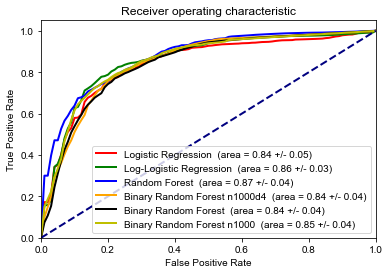

In [120]:
plot_roc(res_ev)

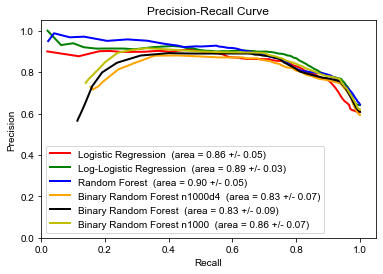

In [121]:
plot_prc(res_ev)

In [122]:
with open('../output/trained_nobg_random_forest.pkl', 'wb') as f:
    pickle.dump(models_ev['Random Forest'], f)

# Phosphosite Fitting


In [91]:
# Load psp statements
from indra.tools import assemble_corpus as ac
from indra.statements import Phosphorylation

In [92]:
psp_path = '../run_assembly/data/bioexp_phosphosite.pkl'
psp_stmts = ac.load_statements(psp_path)

INFO: [2020-12-09 10:50:38] indra.tools.assemble_corpus - Loading ../run_assembly/data/bioexp_phosphosite.pkl...
INFO: [2020-12-09 10:50:38] indra.tools.assemble_corpus - Loaded 15957 statements


In [93]:
def filter_psp_stmts(stmts):
    stmts = ac.filter_by_type(stmts, Phosphorylation)
    stmts = ac.filter_genes_only(stmts, specific_only=True)
    stmts = ac.filter_human_only(stmts)
    return stmts
psp_stmts_filt = filter_psp_stmts(psp_stmts)

INFO: [2020-12-09 10:50:42] indra.tools.assemble_corpus - Filtering 15957 statements for type Phosphorylation...
INFO: [2020-12-09 10:50:42] indra.tools.assemble_corpus - 15957 statements after filter...
INFO: [2020-12-09 10:50:42] indra.tools.assemble_corpus - Filtering 15957 statements for ones containing genes only...
INFO: [2020-12-09 10:50:42] indra.tools.assemble_corpus - 15901 statements after filter...
INFO: [2020-12-09 10:50:42] indra.tools.assemble_corpus - Filtering 15901 statements for human genes only...
INFO: [2020-12-09 10:50:42] indra.tools.assemble_corpus - 9398 statements after filter...


In [94]:
psp_hashes = [s.get_hash() for s in psp_stmts_filt]

In [95]:
cur_hashes = set(kge_df.stmt_hash.values)
in_psp_hashes = cur_hashes.intersection(psp_hashes)
not_in_psp_hashes = cur_hashes.difference(in_psp_hashes)

In [96]:
psp_df = kge_df[kge_df['stmt_hash'].isin(not_in_psp_hashes) &
                (kge_df['stmt_type'] == 'Phosphorylation')]


In [97]:
psp_df

,stmt_num,stmt_hash,agA_name,agA_ns,agA_id,stmt_type,agB_name,agB_ns,agB_id,correct,...,sparser,medscan,hprd,bel,trips,trrust,signor,isi,rlimsp,biopax
4,5,5358719315365482,p38,FPLX,p38,Phosphorylation,RELA,HGNC,9955,1,...,0,0,0,0,0,0,0,0,0,0
5,6,-17665662151823120,VEGFC,HGNC,12682,Phosphorylation,p38,FPLX,p38,1,...,1,0,0,0,0,0,0,0,0,0
49,50,-1188869864170409,WNT5A,HGNC,12784,Phosphorylation,DVL2,HGNC,3086,1,...,8,0,0,0,0,0,0,0,0,0
54,55,-55474658534404,PRKCD,HGNC,9399,Phosphorylation,CDKN1A,HGNC,1784,1,...,6,0,0,0,0,0,0,0,0,0
95,96,22330930554731461,CK2,FPLX,CK2,Phosphorylation,ETV7,HGNC,18160,1,...,7,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,1437,-3036237952140739,SRC,HGNC,11283,Phosphorylation,FUNDC1,HGNC,28746,0,...,0,0,0,0,0,0,0,0,0,0
1364,1438,-256008474476057,MTOR,HGNC,3942,Phosphorylation,PGK1,HGNC,8896,0,...,0,0,0,0,0,0,0,0,0,0
1365,1439,440569696375259,HGF,HGNC,4893,Phosphorylation,CTNNB1,HGNC,2514,1,...,0,0,0,0,0,0,0,0,0,0
1366,1440,16194778892146071,RPS6KA1,HGNC,10430,Phosphorylation,YBX1,HGNC,8014,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
# ROC and PRC comparison for different models, using all data
#train_df = kge_df[reader_list + ['correct']]
models_ev = {
    'Logistic Regression': LogisticRegression(),
    'Log-Logistic Regression': LogLogisticRegression(),    
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
    #'Random Forest': RandomForestClassifier(),
    'Binary Random Forest n1000d4': BinaryRandomForest(n_estimators=1000, max_depth=4),
    'Binary Random Forest': BinaryRandomForest(),
    'Binary Random Forest n1000': BinaryRandomForest(n_estimators=1000)
    #'Belief Orig': BeliefModel(reader_list),
    #'Belief Binomial': BeliefModel(reader_subset, model_class=BinomialStmt),
    #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
    #                           nwalkers=100, burn_steps=100, sample_steps=100)
    #'GaussianNB': GaussianNB(),
}

res_ev = eval_models_relation(models_ev, psp_df, reader_list, train_test_split,
                              test_split=0.2, num_folds=20, cols_to_include=None)

  0%|          | 0/20 [00:00<?, ?it/s]

['reach', 'sparser', 'medscan', 'rlimsp', 'trips', 'correct']


100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


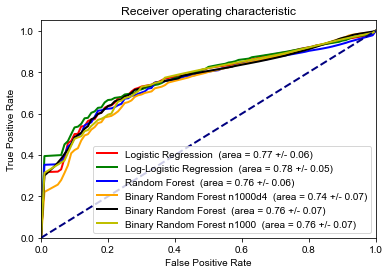

In [99]:
plot_roc(res_ev)

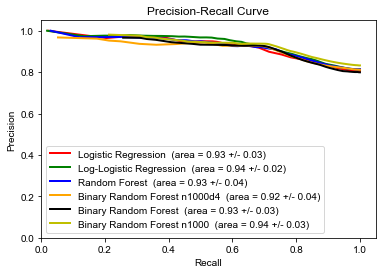

In [100]:
plot_prc(res_ev)

In [104]:
with open('../output/trained_nopsp_loglogreg.pkl', 'wb') as f:
    pickle.dump(models_ev['Log-Logistic Regression'], f)
    
with open('../output/trained_nopsp_logreg.pkl', 'wb') as f:
    pickle.dump(models_ev['Logistic Regression'], f)

# Orphans

In [ ]:
# Functions for generating datasets assuming different assumptions.
def all_ind(r_names, size, p_readers, p_correct):
    all_cols = ['correct'] + r_names
    all_p = [p_correct] + p_readers
    arrs = []
    for varn, p in zip(r_names, p_readers):
        arr = np.random.choice([0, 1], size=size, p=[1-p, p])
        arrs.append(arr)
    mat = np.vstack(arrs).T
    df_reader = pd.DataFrame(mat, columns=r_names)
    # Filter out the rows with all 0s from readers
    reader_arr = df_reader[df_reader.any(1)].values
    # Construct the column for correctness
    corr_arr = np.random.choice([0, 1], size=(reader_arr.shape[0], 1),
                                p=[1 - p_correct, p_correct])
    full_arr = np.hstack([corr_arr, reader_arr])
    df = pd.DataFrame(full_arr, columns=all_cols)
    return df


### Examining probabilities and assumptions

In [ ]:
#rs_only_df = kge_df[(kge_df[r1] > 0) | (kge_df[r2] > 0)]
#rs_only_df = kge_df[(kge_df[r1] > 0) | (kge_df[r2] > 0) | (kge_df[r3] > 0)]
# Readers are same / 100% dependent
#rs_only_df[r2] = kge_df[r1]
# Readers are independent
#rs_only_df[r2] = rs_only_df[r2].sample(frac=1).values
#rs_only_df = kge_df

# Test for conditional independence--is R1 independent of R2 given corr?
print(f"p({reader1} | {reader2}, corr)", prob([(r1, 1)], [(r2, 1), ('correct', 1)]))
print(f"p({reader1} | corr)", prob([(r1, 1)], [('correct', 1)]))
print()

# Are r1 and r2 independent?
print(f"p({reader1} and {reader2})", prob([(r1, 1), (r2, 1)]))
print(f"p({reader1}) * p({reader2})", prob([(r1, 1)]) * prob([(r2, 1)]))
print()

print(f"Ground truth: p(corr, {reader1}, {reader2})", prob([('correct', 1), (r1, 1), (r2, 1)]))
print(f"Ground truth: p({reader1}, {reader2})", prob([(r1, 1), (r2, 1)]))
print(f"Ground truth: p(corr | {reader1}, {reader2})", prob([('correct', 1)], [(r1, 1), (r2, 1)]))
print(f"Assume corr CI of {reader1} given {reader2} = p(corr | {reader2})",
      prob([('correct', 1)], [(reader2, 1)]))


In [ ]:
# Both readers > 0
df = bin_df
print(r1, "only", len(df[(df[r1] > 0) & (df[r2] == 0)]))
print(r2, "only", len(df[(df[r2] > 0) & (df[r1] == 0)]))
print(r1, "and", r2, len(df[(df[r2] > 0) & (df[r1] > 0)]))
print("total", len(df))

In [ ]:
# 1. The joint event
prob([('correct', 1), (r1, 1), (r2, 1)])

In [ ]:
# 2. By chain rule (exact vs above)
prob([(r1, 1)]) * prob([('correct', 1)], [(r1, 1)]) * prob([(r2, 1)], [('correct', 1), (r1, 1)])

In [ ]:
# 3. What we want to know: p(c|r,s) (exact)
prob([('correct', 1)], [(r1, 1), (r2, 1)])

In [ ]:
# 4. What we want to know, by defn of cond prob vs. above (exact)
prob([('correct', 1), (r1, 1), (r2, 1)]) / prob([(r1, 1), (r2, 1)]) #

In [ ]:
# 5 Applying chain rule (combining 2 and 4)
((prob([(r1, 1)]) * prob([('correct', 1)], [(r1, 1)]) * prob([(r2, 1)], [('correct', 1), (r1, 1)])) / 
     prob([(r1, 1), (r2, 1)]))

In [ ]:
# 6. Applying Bayes rule for p(r2|c,r1)
((prob([(r1, 1)]) * prob([('correct', 1)], [(r1, 1)]) * prob([('correct', 1), (r1, 1)], [(r2, 1)]) * prob([(r2, 1)])) / 
     (prob([(r1, 1), (r2, 1)])*prob([('correct', 1)], [(r1, 1)])*prob([(r1, 1)])))

In [ ]:
# 7. Cancel terms * (Exact)
# p(c,r1|r2) * p(r2)
# ------------------
#      p(r1,r2)
exact = (prob([('correct', 1), (r1, 1)], [(r2, 1)]) * prob([(r2, 1)])) / (prob([(r1, 1), (r2, 1)]))
print("Exact:", exact)

# 8. Complete identity/correlation
redundant = prob([('correct', 1)], [(r2, 1)])
print("Redundant:", redundant)

# 9. Complete independence
indep = (prob([('correct', 1)], [(r1, 1)]) * prob([('correct', 1)], [(r2, 1)])) / prob([('correct', 1)])
print("Independent", indep)

# 10. Like coin flips
coins = 1 - (1 - prob([('correct', 1)], [(r1, 1)])) * (1 - prob([('correct', 1)], [(r2, 1)])) 
print("Joint belief:", coins)

# 8. Substituting approximation: p(c,r1|r2) = p(c|r2)*p(r1|r2)
# p(c|r2) * p(r1|r2) * p(r2)
# --------------------------
#      p(r1,r2)
#(prob(['correct'], [r2]) * prob([r1], [r2]) * prob([r2])) / (prob([r1, r2]))

# Full independence:
# p(c|r2) * p(r1) * p(r2)
# -------------------------- = p(c|r2)
#      p(r1) * p(r2)

# Full dependence:
# p(c|r2) * 1 * p(r2)
# --------------------------
#      p(r1,r2)

#((prob([r1]) * prob(['correct'], [r1]) * prob([r1], [r2]) * prob([r2])) / 
#     (prob([r1, r2])*prob(['correct'], [r1])*prob([r1])))

In [ ]:
# An expression that we need.
# If only one reader, all rows will have at least one evidence from that reader, whether correct or not
prob([(r1, 1), (r2, 1)], [('correct', 1)])

In [ ]:
# Approximation of above - if readers are the same, this should be quite wrong; if independent, quite right
prob([(r1, 1)], [('correct', 1)]) * prob([(r2, 1)], [('correct', 1)])

In [ ]:
prob([(r1, 1)], [('correct', 1)])

In [ ]:
# Bayes rule vs p(r1,r2|c) - exact
(prob([('correct', 1)], [(r1, 1), (r2, 1)]) * prob([(r1, 1), (r2, 1)])) / prob([('correct', 1)])

In [ ]:
# Rearrange from above - exact
(prob([(r1, 1), (r2, 1)], [('correct', 1)]) * prob([('correct', 1)])) / prob([(r1, 1), (r2, 1)])

In [ ]:
# Now, apply our assumption that p(r,s|c) ~= p(r|c)p(s|c)
# A hint in the fact that effectiveness of this changes when we filter dataset to statements with at least
# one of the two readers
(prob([(r1, 1)], [('correct', 1)]) * prob([(r2, 1)], [('correct', 1)]) * prob([('correct', 1)])) / prob([(r1, 1), (r2, 1)])

In [ ]:
prob([('correct', 1)])

### Working with Knowledge Graph Embeddings

In [ ]:
# Load previous curation dataset and the KGE scores
with open('curation_dataset.pkl', 'rb') as f:
    data_dict = pickle.load(f)

kge_df_scores = pd.read_csv('kge_dataset_w_scores.csv', index_col=0)
kge_df_scores.head()

In [ ]:
# Prepare the scores data for the join
kds = kge_df_scores
kds = kds.rename(columns={'subject': 'agA_name', 'object': 'agB_name', 'relation': 'stmt_type'})
kds = kds.set_index([kds.agA_name, kds.stmt_type, kds.agB_name, kds.correct])
kds.head()

In [ ]:
# Set the multiindex on the main dataframe and do the join
kge_join = kge_df.set_index([kge_df.agA_name, kge_df.stmt_type, kge_df.agB_name, kge_df.correct]).join(kds, rsuffix='sc')
kge_join = kge_join.set_index(kge_join.stmt_num)
kge_join = kge_join.drop(columns=['agA_namesc', 'stmt_typesc', 'agB_namesc', 'correctsc'])
kge_join = kge_join[~pd.isna(kge_join.score)] # Keep only the rows with KGE scores
kge_join.head()

### Experimenting with BL expansion

In [ ]:
# This section shows that the expansion code works and is meant for experimenting
# with belief/prob/BL comparisons for different reader combinations
# p(R1=1, R2=1, corr=1)
r1 = 'reach'
r2 = 'sparser'
r3 = 'medscan'
r4 = 'trips'
r5 = 'rlimsp'
Y = [(r1, 1), (r2, 1), (r3, 1), (r4, 1), (r5, 1), ('correct', 1)]
#Y = [(r1, 0), (r2, 0), (r3, 0), (r4, 0), (r5, 1), ('correct', 1)]
#Y = [(r1, 1), ('correct', 1)]

#Y = [(r1, 1), ('correct', 1)]
#Y = [(r1, 1), (r2, 0), ('correct', 1)]

given_vars = [r1, r2, r3, r4, r5]
given_vals = [(col, val) for col, val in Y if col in given_vars]

def belief(cols):
    prod = 1
    for col in cols:
        col_df = bin_df_sub[bin_df_sub[col] == 1]
        err = prob([('correct', 0)], df=col_df)
        prod *= err
    return 1 - prod

print(f"Ground truth: p(corr=1 | {str(given_vals)})", prob([('correct', 1)], given_vals))
print("Belief estimate:", belief([r1, r2]))

bl = BLPredictor(df=bin_df_sub)
#print(f"Ground truth: p({str(Y)})", prob(Y))
for order in range(1, len(Y)+1):
    if True or order == 2:
        print(f"Bahadur-Lazarsfeld Order {order}:", bl.bahadur_laz(col_vals=Y, max_order=order) / prob(given_vals))

### Experiments with Naive Bayes analysis

In [ ]:
def dep_deriv(x_dict, pa_dict, df):
    correct_vals = (0, 1)
    dd_dict = {}
    for c_val in correct_vals:
        for x_name, x_val in x_dict.items():
            pa_names = pa_dict[x_name]
            pa_vals = [(pa, x_dict[pa]) for pa in pa_names if pa != 'correct']
            pa_vals.append(('correct', c_val))
            numer = prob([(x_name, x_val)], pa_vals, df=df)
            denom = prob([(x_name, x_val)], [('correct', c_val)], df=df)
            dd_dict[(x_name, c_val)] = numer / denom
    return dd_dict

def ddrg(x_dict, pa_dict, df):
    dd_dict = dep_deriv(x_dict, pa_dict, df)
    ddrg = {}
    for x_name in x_dict:
        ddrg[x_name] = dd_dict[(x_name, 1)] / dd_dict[(x_name, 0)]
    return ddrg

def prob_anb(x_dict, pa_dict, df):
    for c_val in (0, 1):
        pc = prob([('correct', c_val)])
        ddrg = 

In [ ]:
pa_dict = {'r1': ['correct'], 'r2': ['r1', 'correct']}
x_dict = {'r1': 1, 'r2': 1}
ddrg(x_dict, pa_dict, df)

## Build single evidence stmt corpus

In [ ]:
ev_curations = {}
for reader in reader_list:
    r_curations = get_raw_curations(reader_input[reader]['source_list'], stmts_by_hash)
    ev_curations.update(r_curations)

Process curations into statements with single evidences:

In [ ]:
def stmt_data_from_curations(curations):
    ev_stmts = []
    ev_corrs = []
    for pa_hash, cur_dict in tqdm(curations.items()):
        stmt = stmts_by_hash[pa_hash]
        for ev in stmt.evidence:
            ev_cur_list = cur_dict.get(ev.get_source_hash())
            # This evidence hasn't been curated
            if ev_cur_list is None:
                continue
            correct_set = set()
            for ev_cur in ev_cur_list:
                # Get whether the curation is correct    
                if ev_cur['tag'] in ('correct', 'hypothesis', 'activity_vs_amt'):
                    correct_set.add(1)
                else:
                    correct_set.add(0)
            # If the correctness set has more than 1 member there is disagreement,
            # so skip
            if len(correct_set) > 1:
                continue
            else:
                correct = list(correct_set)[0]
            # Make a copy of the statement with the single curated evidence
            stmt_copy = copy(stmt)
            stmt_copy.evidence = [ev]
            # Store the 1-evidence stmt and the corresponding correctness
            ev_stmts.append(stmt_copy)
            ev_corrs.append(correct)
    return (ev_stmts, ev_corrs)

ev_stmts, ev_corrs = stmt_data_from_curations(ev_curations)

# References

References:

Logistic regression: https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

ROC curves: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

Controlling the threshold in Logistic Regression in Scikit Learn: https://stackoverflow.com/questions/28716241/controlling-the-threshold-in-logistic-regression-in-scikit-learn

sklearn.metrics.precision_recall_curve: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html


Anton Yuryev for providing Medscan corpus. MITRE for discussion over the years.